# Manejo de Datos Faltantes: Detección y Exploración


Configuración de ambiente de trabajo


In [2]:
# %pip install pyjanitor matplotlib==3.5.1 missingno numpy pandas pyreadr seaborn session-info upsetplot==0.6.1

Librerías

In [3]:
import janitor
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns
import upsetplot

Importar funciones personalizadas

In [4]:
%run pandas-missing-extension.ipynb

Configurar el aspecto general de las gráficas

In [5]:
%matplotlib inline
sns.set(
    # Tamaño de las gráficas
    rc={
        "figure.figsize": (10, 10)
    }
)

# Estilo de cuadrícula blanca
sns.set_style("whitegrid")

## Introducción a los valores faltantes

### ¿Por qué explorar y lidiar con los valores faltantes?

Cuando se trabaja con conjuntos de datos (especialmente con conjuntos muy grandes) es normal encontrarse con que faltan algunos valores; la ausencia de estos valores nos puede llevar a sacar conclusiones erróneas e incluso contradictorias. 

Ignorar los valores faltantes puede introducir **sesgos** en el análisis y en los modelos: tenemos un valor real y debido a esos valores faltantes entonces podemos subestimar o sobreestimar dicho valor.

Por otro lado, muchos de los algoritmos disponibles para analizar datos no aceptan valores faltantes , no saben lidiar con ellos, así que eliminarán los datos y pueden llegar a fallar.

La mejor manera de tratar con los datos faltantes es no tenerlos, pero la realidad es que muchos conjuntos de datos tendrán valores faltantes y por eso es importante saber tratarlos y entenderlos.


### Operaciones con valores faltantes

#### Python

Python por defecto tiene una forma de representar a los valores faltantes con **None**

In [6]:
print(
    None or True,
    None or False,
    None == None,
    None is None,
    sep = "\n"
)

True
False
True
True


Vemos que podemos realizar comparaciones booleanas con *None*. Miramos ahora qué sucede cuando hacemos operaciones con valores numéricos y booleanos.

In [7]:
print(
    None + True,
    None / 3,
    sep = "\n"
)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'bool'

Como vemos, Python no soporta las operaciones con valores numéricos o booleanos.

In [8]:
print(type(None))

<class 'NoneType'>


*None* es de tipo **NoneType** y esta clase no tiene definida las formas para lidiar con estas operaciones.

#### Numpy

Numpy representa los valores faltantes con **np.nan**

In [9]:
print(
    np.nan or True,
    np.nan or False,
    np.nan == np.nan,
    np.nan is np.nan,
    sep = "\n"
)

nan
nan
False
True


Vemos cosas interesantes, np.nan no es igual a np.nan, pero al utilizar *is* sí nos arroja verdadero. Ahora miremos qué sucede al realizar operaciones.

In [10]:
print(
    np.nan * 2,
    np.nan / 7,
    type(np.nan),
    sep = "\n"
)

nan
nan
<class 'float'>


Vemos qué sí podemos realizar operaciones con np.nan, solo que nos regresa como resultado nan. Podemos realizar estas operaciones ya que np.nan es en realidad de tipo *float*.

La verdadera forma para preguntar si algo es de tipo nan es utilizando *isnan()*

In [11]:
print(
    np.isnan(np.nan)
)

True


#### Pandas

Pandas tiene varias formas de representar datos faltantes: np.nan, None y el por defecto **pd.NA**

In [12]:
# Creamos un dataframe de prueba con algunos datos faltantes
testMissingDf = pd.DataFrame.from_dict(
    data = dict(
        x=[0, 1, np.nan, np.nan, None],
        y=[0, 1, pd.NA, np.nan, None]
    )
)
testMissingDf

,x,y
0,0.0,0
1,1.0,1
2,NaN,<NA>
3,NaN,NaN
4,NaN,None


Utilizando la función *isna()* obtenemos el conjunto de datos pero de forma booleana, donde True significa que es un valor faltante.

In [13]:
testMissingDf.isna()

,x,y
0,False,False
1,False,False
2,True,True
3,True,True
4,True,True


También podemos utilizar la función *isnull()* que tiene el mismo comportamiento.

In [14]:
testMissingDf.isnull()

,x,y
0,False,False
1,False,False
2,True,True
3,True,True
4,True,True


Pandas nos permite buscar los valores faltantes de una columna específica.

In [15]:
testMissingDf.x.isnull()

0    False
1    False
2     True
3     True
4     True
Name: x, dtype: bool

In [16]:
testMissingDf.y.isna()

0    False
1    False
2     True
3     True
4     True
Name: y, dtype: bool

Podríamos crear Series de datos con diferentes tipos de datos.

In [17]:
pd.Series([1, np.nan])

0    1.0
1    NaN
dtype: float64

Si por ejemplo tuviéramos una fecha vemos que el valor faltante no será NaN sino que será *NaT*

In [18]:
pd.Series([pd.to_datetime("2022-01-01"), np.nan])

0   2022-01-01
1          NaT
dtype: datetime64[ns]

Algo curioso es que Pandas no detecta el -1 como un valor faltante aunque este es usado en muchos casos para representarlos.

In [19]:
pd.Series([-1]).isnull()

0    False
dtype: bool

### Cargar los conjuntos de datos

#### Pima Indians Diabetes

In [20]:
diabetesDf = pd.read_csv(
    "pima-indians-diabetes.csv",
    sep = ",",
    names = [
        "pregnancies",
        "glucose",
        "blood_pressure",
        "skin_thickness",
        "insulin",
        "bmi",
        "diabetes_pedigree_function",
        "age",
        "outcome",
    ]
    )

#### naniar(oceanbuoys, pedestrian, riskfactors)

In [21]:
# Estos datasets vienen en un archivo .rda
datasetOcean = pyreadr.read_r("oceanbuoys.rda")
print(datasetOcean.keys())
oceanbuoysDf = datasetOcean["oceanbuoys"]

odict_keys(['oceanbuoys'])


In [22]:
# Estos datasets vienen en un archivo .rda
datasetPedest = pyreadr.read_r("pedestrian.rda")
print(datasetPedest.keys())
pedestrianDf = datasetPedest["pedestrian"]

odict_keys(['pedestrian'])


In [23]:
# Estos datasets vienen en un archivo .rda
datasetRisk = pyreadr.read_r("riskfactors.rda")
print(datasetRisk.keys())
riskfactorsDf = datasetRisk["riskfactors"]

odict_keys(['riskfactors'])


#### Verificar la carga

In [24]:
oceanbuoysDf.shape, pedestrianDf.shape, riskfactorsDf.shape, diabetesDf.shape

((736, 8), (37700, 9), (245, 34), (768, 9))

### Tabulación de datos faltantes

Tabular es expresar valores, magnitudes u otros datos por medio de tablas.

- Siempre hay que empezar los análisis con preguntas simples que lleven a un valor:
    - ¿Cuántos valores deberían existir en el conjunto de datos?
- Construir resúmenes por variables y observaciones:
    - ¿Cuántos valores faltantes existen por cada variable?
    - ¿Cuántas variables tienen X número de valores faltantes?
    - ¿Cuántas observaciones tienen X número de valores faltantes?
- Hay que salir de la caja y hacer más preguntas:
    - ¿Cuántos valores faltantes tengo en una variable cada X pasos?
    - ¿Cuál es la racha de valores completos y faltantes en una variable?

#### Análisis de valores faltantes en el dataframe riskfactors

Mostrar los valores faltantes en el dataframe de forma general

In [25]:
riskfactorsDf.isna()

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
241,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
242,False,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
243,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False


Filas y columnas del dataframe

In [26]:
riskfactorsDf.shape

(245, 34)

Registros en el dataframe

In [27]:
riskfactorsDf.size

8330

**Utilizamos las funciones creadas para extender la funcionalidad de Pandas**

Número de valores no nulos en el dataframe

In [28]:
riskfactorsDf.missing.number_complete()

7144

Número de valores faltantes en el dataframe

In [29]:
riskfactorsDf.missing.number_missing()

1186

##### Resúmenes tabulares de valores faltantes

**Resumen por variable**

*missing_variable_summary()* nos muestra una tabla que resume el número de valores faltantes de cada variable, el número total de registros y el porcentaje de valores faltantes.

In [30]:
riskfactorsDf.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,state,0,245,0.000000
1,sex,0,245,0.000000
2,age,0,245,0.000000
3,weight_lbs,10,245,4.081633
4,height_inch,2,245,0.816327
5,bmi,11,245,4.489796
6,marital,1,245,0.408163
7,pregnant,215,245,87.755102
8,children,0,245,0.000000
9,education,1,245,0.408163


**Tabulación del resumen por variable**

*missing_variable_table()* nos da una tabla que contiene la cantidad de valores faltantes que existen en una variable y cúantas variables tienen esa cantidad de valores faltantes y el porcentaje de variables que tienen esa cantidad de datos faltantes.

In [31]:
riskfactorsDf.missing.missing_variable_table()

,n_missing_in_variable,n_variables,pct_variables
0,0,10,29.411765
1,8,6,17.647059
2,2,4,11.764706
3,3,3,8.823529
4,1,2,5.882353
5,10,1,2.941176
6,11,1,2.941176
7,113,1,2.941176
8,128,1,2.941176
9,134,1,2.941176


**Resumen por caso u observación**

*missing_case_summary()* nos devuelve una tabla que nos indica el número de fila, cuántos valores faltantes tiene esa fila y qué porcentaje representa ese número de valores faltantes.

In [32]:
riskfactorsDf.missing.missing_case_summary()

,case,n_missing,pct_missing
0,0,6,16.666667
1,1,6,16.666667
2,2,7,19.444444
3,3,12,33.333333
4,4,5,13.888889
...,...,...,...
240,240,6,16.666667
241,241,5,13.888889
242,242,3,8.333333
243,243,2,5.555556


**Tabulación del resumen por fila**

*missing_case_table()* nos devuelve una tabla que nos dice el número de valores faltantes en una fila, cuántas filas tienen esa cantidad de valores faltantes y qué porcentaje representan.

In [33]:
riskfactorsDf.missing.missing_case_table()

,n_missing_in_case,n_cases,pct_case
0,4,49,20.000000
1,5,45,18.367347
2,7,39,15.918367
3,6,36,14.693878
4,2,31,12.653061
5,3,30,12.244898
6,1,4,1.632653
7,8,3,1.224490
8,12,3,1.224490
9,15,2,0.816327


##### Intervalos de valores faltantes


Identificar el número de valores faltantes por cada 50 filas para la variable *weight_lbs*.

In [34]:
(
    riskfactorsDf.missing.missing_variable_span(
        # Especificamos la variable
        variable = "weight_lbs",
        # Partimos en bloques de 50 filas
        span_every = 50
    )
)

,span_counter,n_missing,n_complete,pct_missing,pct_complete
0,0,1,49,2.000000,98.000000
1,1,5,45,10.000000,90.000000
2,2,1,49,2.000000,98.000000
3,3,1,49,2.000000,98.000000
4,4,2,43,4.444444,95.555556


##### Racha de valores faltantes

Número de registros consecutivos que están completos seguido del número de registros consecutivos que tienen datos faltantes

In [35]:
riskfactorsDf.missing.missing_variable_run(variable = "weight_lbs")

,run_length,is_na
0,14,complete
1,1,missing
2,45,complete
3,1,missing
4,5,complete
5,1,missing
6,12,complete
7,1,missing
8,10,complete
9,2,missing


Todo esto sirve para encontar picos donde se acumulan valores faltantes.

#### Visualización de valores faltantes

Las tablas nos permiten conocer las variables con valores faltantes y su respectivo porcentaje. Sin embargo, para identificar apariciones conjuntas de valores de datos las tablas no sirven; para ello utilizamos **upsetplots** ya que establecen relaciones entre diferentes variables.

##### Variables

Visualización de los valores faltantes para cada variable mediante un gráfico de paleta

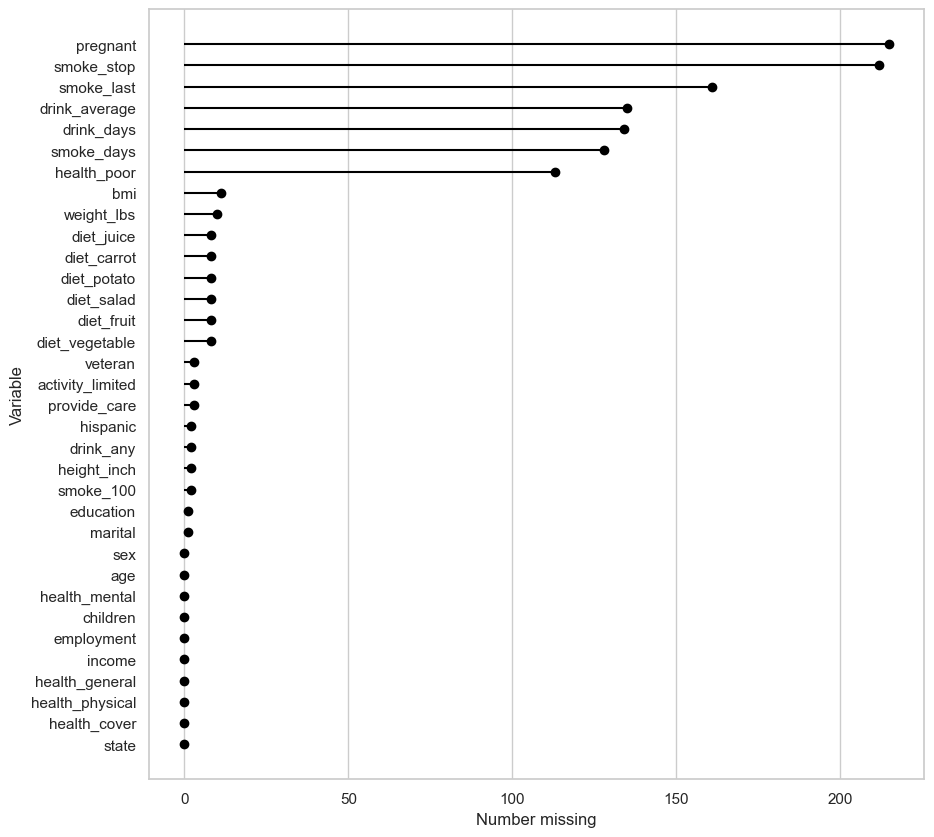

In [36]:
riskfactorsDf.missing.missing_variable_plot()

##### Filas

Visualización de los valores faltantes en los registros o filas

In [37]:
riskfactorsDf.missing.missing_case_plot

<bound method MissingMethods.missing_case_plot of <__main__.MissingMethods object at 0x000001A3C5D89A60>>

Visualización de valores faltantes para bloques de X registros

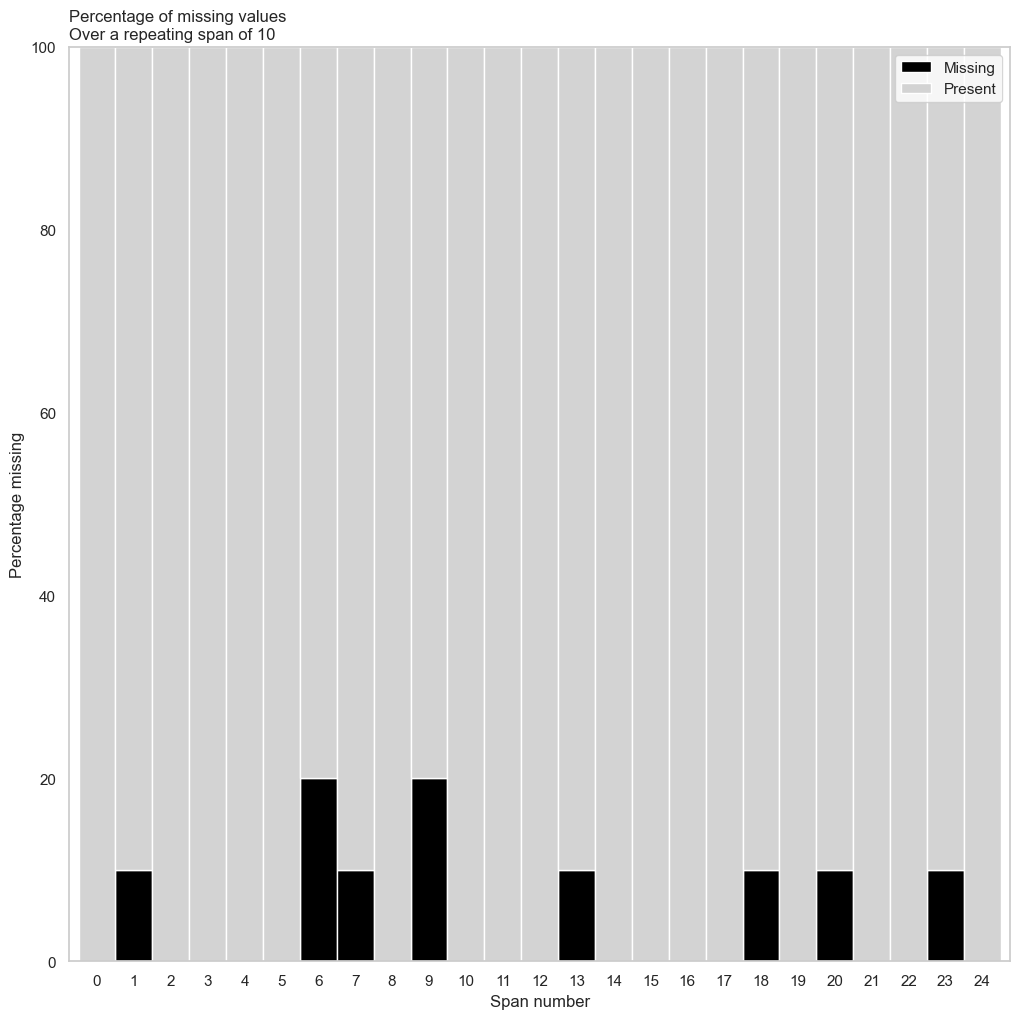

In [38]:
(
    riskfactorsDf.missing.missing_variable_span_plot(
        variable = "weight_lbs",
        span_every = 10,
        rot = 0
    )
)

##### Usando missingno

Visualización de los datos faltantes para todas las variables del dataframe.

Los valores completos son las barras y los valores faltantes están representados por los espacios en blanco.

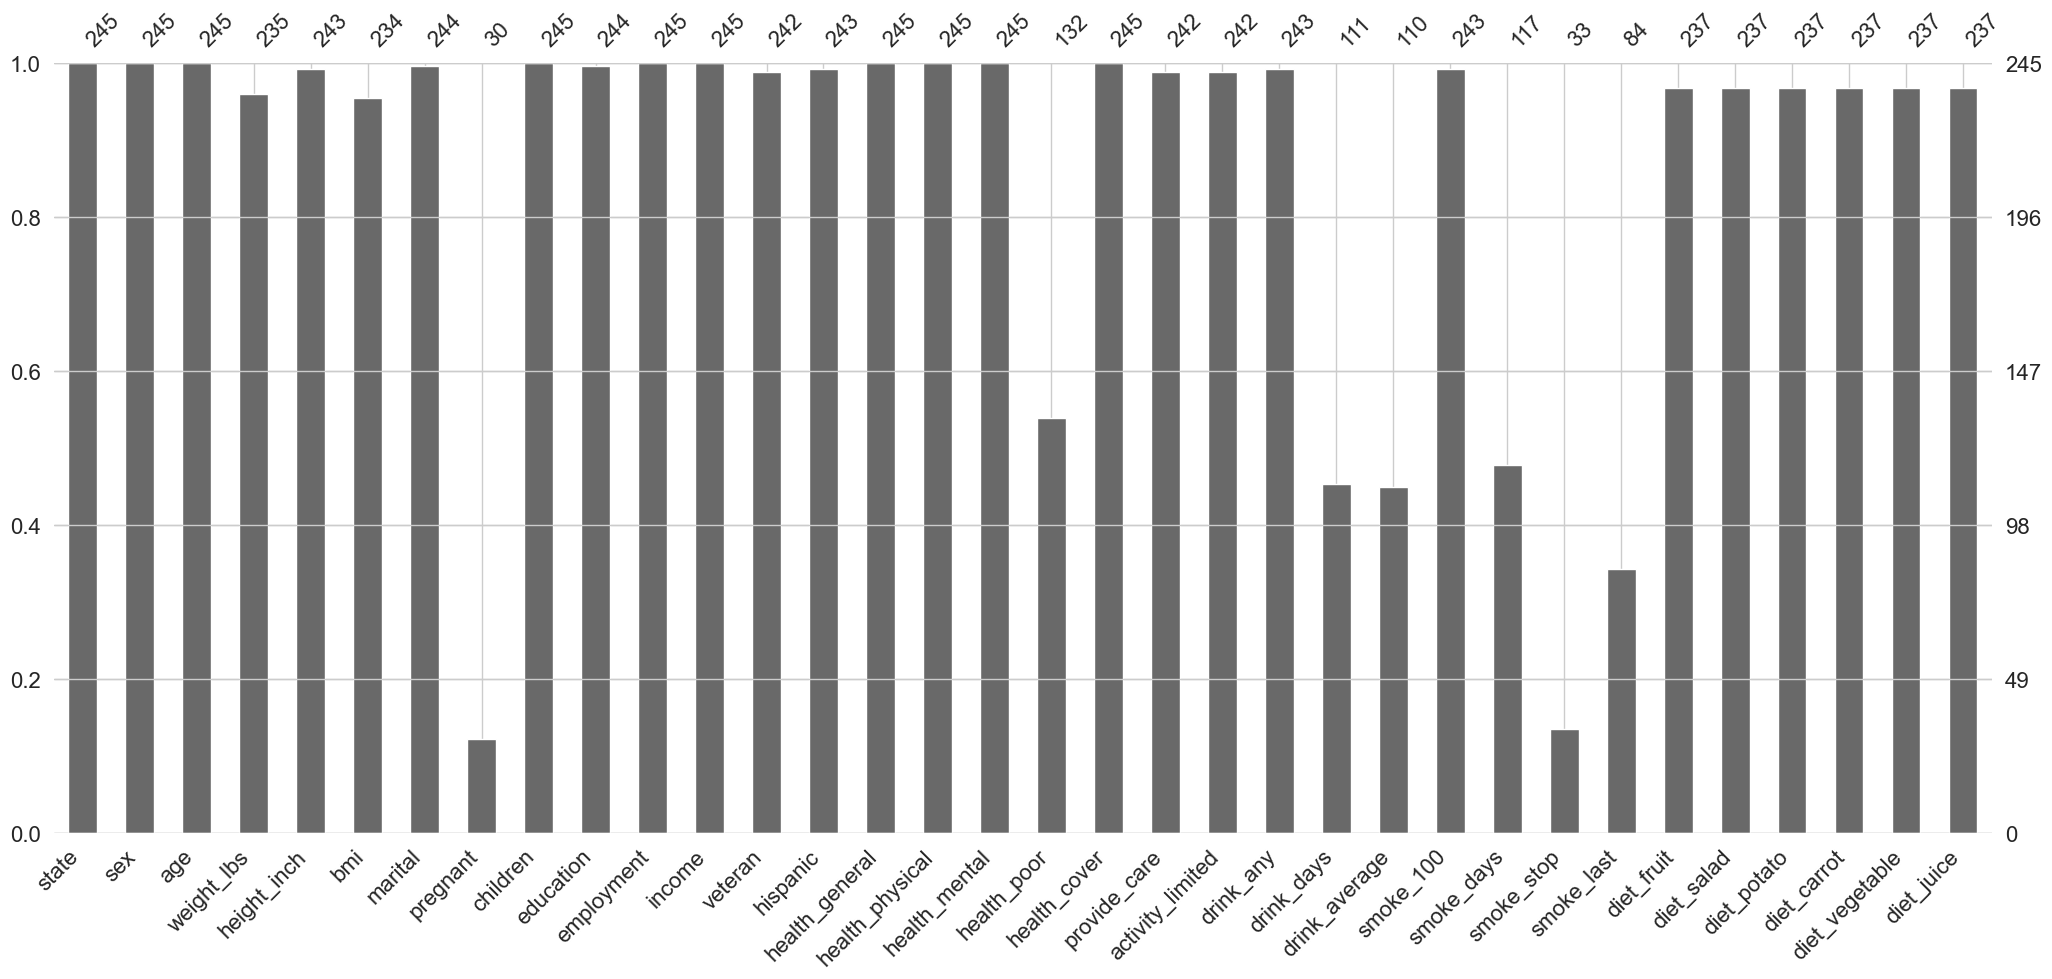

In [39]:
missingno.bar(df = riskfactorsDf)
plt.show()

Visualización de los valores faltantes para cada variable mediante una matriz.

La barra representa los valores que están completos y los espacios en blanco representan los valores faltantes.

A la derecha vemos si hay algún pico de valores faltantes en ciertos lugares.

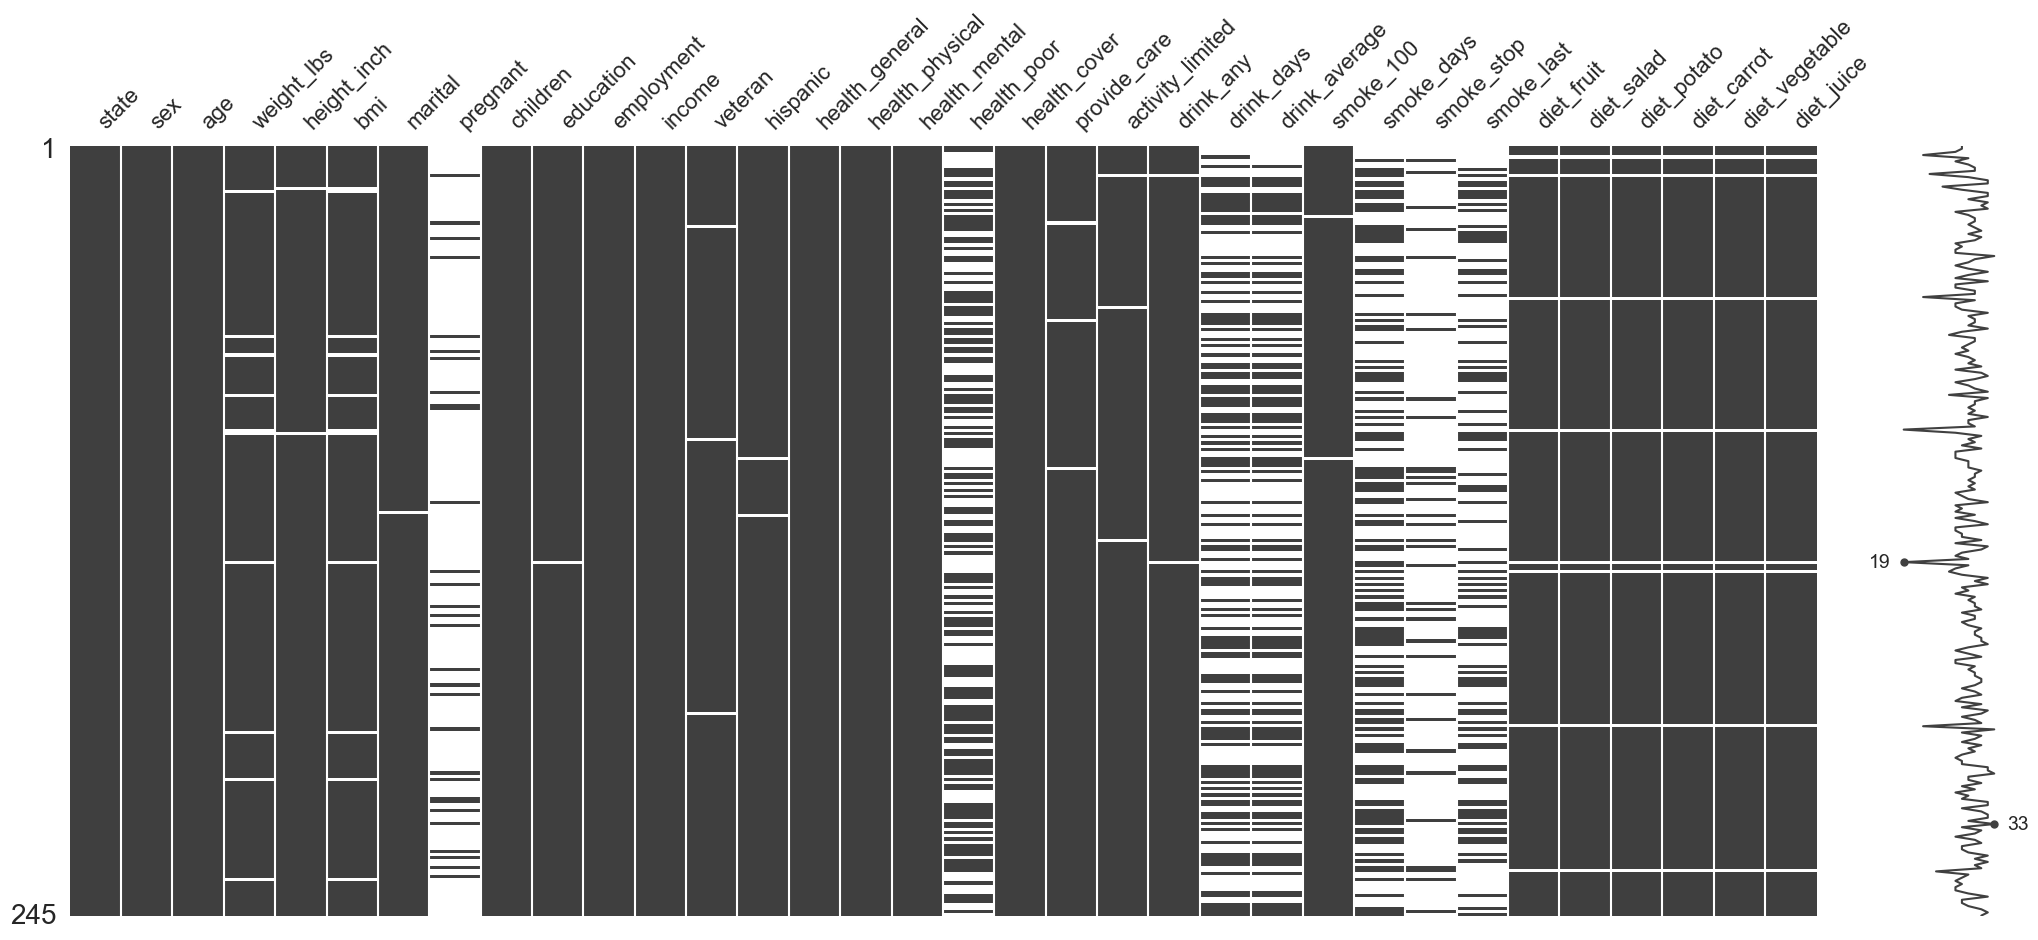

In [40]:
missingno.matrix(df = riskfactorsDf)
plt.show()

##### Variables conjuntas

Visualización de apariciones conjuntas en varias variables

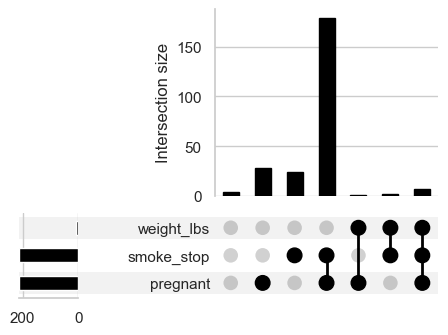

In [41]:
(
    riskfactorsDf.missing.missing_upsetplot(
        # Variables que queremos graficar
        variables = ["pregnant", "weight_lbs", "smoke_stop"],
        # Tamaño de la figura
        element_size = 30
    )
)
plt.show()

## Manipulación inicial de valores faltantes

### Codificación de valores faltantes

Asumir que los valores faltantes siempre vendrán en un único formato es un error.

Algunas formas en las que se pueden presentar los datos faltantes son: NA, N/A, na, missing, Not Available, -1, -77, -99 y muchas otras.

Si no tenemos en cuenta estos formatos de datos faltantes es posible que se nos escapen y por ello introduzcamos ruido al momento de analizar los datos.

#### Valores comúnmente asociados a valores faltantes

**Cadenas de texto**

In [42]:
commonNaStrings = (
    "missing",
    "NA",
    "N A",
    "N/A",
    "#N/A",
    "NA ",
    " NA",
    "N /A",
    "N / A",
    " N / A",
    "N / A ",
    "na",
    "n a",
    "n/a",
    "na ",
    " na",
    "n /a",
    "n / a",
    " a / a",
    "n / a ",
    "NULL",
    "null",
    "",
    "?",
    "*",
    ".",
)

**Números**

In [43]:
commonNaNumbers = (
    -9, 
    -99, 
    -999, 
    -9999, 
    9999, 
    66, 
    77, 
    88, 
    -1
)

#### ¿Cómo encontrar los valores comúnmente asociados a datos faltantes?

In [44]:
missingDataExampleDf = pd.DataFrame.from_dict(
    dict(
        x = [1, 3, "NA", -99, -98, -99],
        y = ["A", "N/A", "NA", "E", "F", "G"],
        z = [-100, -99, -98, -101, -1, -1]
    )
)

missingDataExampleDf

,x,y,z
0,1,A,-100
1,3,N/A,-99
2,NA,NA,-98
3,-99,E,-101
4,-98,F,-1
5,-99,G,-1


Si utilizamos la función personalizada para el total de valores nulos obtenemos lo siguiente:

In [45]:
missingDataExampleDf.missing.number_missing()

0

Parece que no tenemos valores faltantes, pero sabemos que en realidad sí están ahí; entonces, ¿Cómo podemos arregar esto?

**Revisar tipos de datos**

In [46]:
missingDataExampleDf.dtypes

x    object
y    object
z     int64
dtype: object

Si miramos la columna X vemos que está llena de números a excepción de un solo registro pero Pandas la reconoce como object; por ello, se puede intuir que en dicha columna podrían haber valores faltantes.

**Revisar valores únicos de las columnas**

In [47]:
missingDataExampleDf.x.unique()

array([1, 3, 'NA', -99, -98], dtype=object)

Vemos lo comentado anteriormente, está lleno de números pero hay un string y debería tratarlo como un valor faltante. 

El problema con unique es que revisamos columna por columna. Si queremos ver todos los valores únicos podemos hacerlo de la siguiente manera:

In [48]:
missingDataExampleDf.select_dtypes(object).apply(pd.unique)

x     [1, 3, NA, -99, -98]
y    [A, N/A, NA, E, F, G]
dtype: object

Con esto buscamos los valores únicos de las columnas de tipo object.

#### Sustituir valores comúnmente asociados a valores faltantes

**Sustitución desde la lectura de datos**

Al momento de leer un archivo, por ejemplo con *pd.read_csv* podemos utilizar *na_filter* para filtrar los valores faltantes que especificamos con *na_values*.

In [49]:
pd.read_csv(
    "missing_data_enconding_example.csv",
    na_filter = True,
    na_values = [-99, -1]
)

,x,y,z
0,1.0,A,-100.0
1,3.0,NaN,NaN
2,NaN,NaN,-98.0
3,NaN,E,-101.0
4,-98.0,F,NaN
5,NaN,G,NaN


Tratar los valores faltantes desde la lectura implica que se conoce el dataset o cómo las personas decidieron almacenar la información.

**Sustitución global**

Una vez ya estemos realizando un análisis y hayamos encontrado los valores faltantes vamos a querer transformarlos. Podremos hacer esto con la función *replace*.

In [50]:
missingDataExampleDf.replace(
    # Especificamos las formas de representar un valor faltante
    to_replace = [-99, "NA"],
    # Especificamos por qué valor los vamos a reemplazar
    value = np.nan
)

,x,y,z
0,1.0,A,-100.0
1,3.0,N/A,NaN
2,NaN,NaN,-98.0
3,NaN,E,-101.0
4,-98.0,F,-1.0
5,NaN,G,-1.0


**Sustitución dirigida**

Solo queremos aplicar ciertas reglas de sustitución para una columna en específico.

In [51]:
missingDataExampleDf.replace(
    # Especificamos los valores a reemplazar
    to_replace = {
        # Creamos un primer diccionario para especificar las columnas
        "x" : {
            # Creamos un segundo diccionario para especificar los valores de cada columna y su reemplazo
            -99 : np.nan
        }
    }
)

,x,y,z
0,1,A,-100
1,3,N/A,-99
2,NA,NA,-98
3,NaN,E,-101
4,-98,F,-1
5,NaN,G,-1


### Conversión de valores faltantes implícitos a explícitos

Supongamos que tenemos la siguiente tabla: <br>
![image.png](imp1.PNG)

¿Cuántos valores faltan?

Aunque a simple vista parece que nuestro dataset está completo y no faltan valores la realidad es otra; a zelda le faltan datos para los tiempos afternoon y nigth. Existen valores ocultos en el dataset y son **implícitos**: <br>
![](imp2.PNG)

Implícito se refiere a todo aquello que se entiende que está incluido pero sin ser expresado de forma directa o  explícitamente.

Un valor faltante implícito indica que el valor faltante debería estar incluido en el conjunto de datos del análisis, sin que este lo diga o lo especifique. Por lo general, son valores que podemos encontrar al pivotar nuestros datos o contabilizar el número de apariciones de combinaciones de las variables de estudio.

In [52]:
implicitToExplicitDf = pd.DataFrame.from_dict(
    data={
        "name": ["lynn", "lynn", "lynn", "zelda"],
        "time": ["morning", "afternoon", "night", "morning"],
        "value": [350, 310, np.nan, 320]
    }
)

implicitToExplicitDf

,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0


#### Estrategias para la identificación de valores faltantes implícitos.

**Pivotar la tabla de datos**

Pivotar es tomar una columna o variable de referencia sobre la cual se quiere extender las categorías de manera que produzca una nueva visualización de los datos en función de esas categorías.

In [53]:
implicitToExplicitDf.pivot_wider(
    # Variable que queremos preservar como una columna para que sus valores sean las filas
    index = "name",
    # Valores que vamos a crear como columnas o categorías
    names_from = "time",
    # Cómo queremos rellenar los valores
    values_from = "value"
)

,name,afternoon,morning,night
0,lynn,310.0,350.0,NaN
1,zelda,NaN,320.0,NaN


Vemos que el resultado es una tabla donde los nombres son las filas y los tiempos son las columnas; de esta manera vemos de forma clara que tenemos tres valores faltantes.

**Cuantificar ocurrencias de n tuplas**

La ocurrencia de n tuplas significa, por ejemplo, cuántas veces aparece lynn en la mañana, o cuántas veces aparece zelda en toda la tabla. Si el número no es igual significa que faltan datos.

In [54]:
implicitToExplicitDf.value_counts(
    # Variable por la cual queremos cuantificar
    subset = ["name"]
).reset_index(
    # Reseteamos el índice asignando como n al conteo
    name = "n"
    )  

,name,n
0,lynn,3
1,zelda,1


Vemos que aparece lynn 3 veces y zelda 1; si sabemos que necesitamos tres mediciones entonces deducimos que a zelda le faltan valores.

Podemos agregar condiciones para filtar la tabla.

In [55]:
implicitToExplicitDf.value_counts(
    # Variable por la cual queremos cuantificar
    subset = ["name"]
).reset_index(
    # Reseteamos el índice asignando como n al conteo
    name = "n"
    ).query(
        # Condición a cumplir para que se muestre en la tabla
        "n < 3"
        )  

,name,n
1,zelda,1


#### Exponer filas faltantes implícitas en explícitas

Estaremos utilizando la función *complete()* que proviene del paquete *janitor*. Janitor nos sirve para crear pipelines de limpieza de datos y *complete* es, en cierto modo, lo contrario a la función *dropna()* de Pandas.

**Exponer n tuplas de valores faltantes**

Vamos a encontar los pares faltantes de *name* y *time*.

In [56]:
implicitToExplicitDf.complete(
    # Especificamos las variables que queremos completar
    "name",
    "time"
)

,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0
4,zelda,afternoon,NaN
5,zelda,night,NaN


Vemos que ahora lynn y zelda tienen sus tres valores para cada tiempo.

**Limitar la exposición de n tuplas de valores faltantes**

En ocasiones no queremos que cada posible par exista.

In [57]:
implicitToExplicitDf.complete(
    # Creamos un diccionario donde la llave es la variable y especificamos los valores que queremos que participen
    {"name" : ["lynn", "zelda"]},
    {"time" : ["morning", "afternoon"]},
    # Ordenamos los valores de manera que primero están los valores que acaba de completar
    sort = True
)

,name,time,value
0,lynn,afternoon,310.0
1,lynn,morning,350.0
2,zelda,afternoon,NaN
3,zelda,morning,320.0
4,lynn,night,NaN


**Rellenar los valores faltantes**

Podemos escoger con qué valor rellenar los datos faltantes.

In [58]:
implicitToExplicitDf.complete(
    # Especificamos las variables
    "name",
    "time",
    # Especificamos el valor con el que se rellenarán los valores faltantes; por defecto es nan
    fill_value = "NA"
)

,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NA
3,zelda,morning,320.0
4,zelda,afternoon,NA
5,zelda,night,NA


**Limitar el relleno de valores faltantes implícitos**

Es posible limitar el proceso de relleno de los valores faltantes.

In [59]:
implicitToExplicitDf.complete(
    # Especificamos las variables
    "name",
    "time",
    # Valor para rellenar los datos faltantes
    fill_value = 0,
    # Limitamos para que solo ponga el valor especificado a los valores faltantes explícitos que ya existían
    explicit = False
)

,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0
4,zelda,afternoon,0.0
5,zelda,night,0.0


### Tipos de valores faltantes

Por lo general hablamos de 3 tipos de valores faltantes: Missing Completely at Random (Perdidos completamente al azar), Missing at Random (Perdidos al azar), Missing not at Random (Perdidos no al azar).

- Missing Completely at Random (MCAR): son datos ocasionados por herramientas que dejan de funcionar sin ninguna razón, o sea, al azar. La localización de los valores faltantes en el conjunto de datos ocurre completamente al azar y no depende de ningún otro dato.
- Missing at Random (MAR): las herramientas necesitan mantenimiento periódico para asegurar su funcionamiento constante y confiable; en las fechas donde se hace mantenimiento sabemos que faltarán datos pero esto está asociado a algo que sabemos que sucede, la fecha de mantenimiento. La localización de los valores faltantes en el conjunto de datos depende de otros valores observados.
- Missing not at Random (MNAR): las herramientas tienen límites y al tratar de hacer seguimiento fuera de sus zonas de medición se generan valores faltantes pero no sabemos que nos faltan estos datos. La localización de los valores faltantes en el conjunto de datos depende de los valores faltantes en sí mismos.

No podemos tener seguridad sobre cuál mecanismo incidió sobre los datos faltantes pero a través de análisis y conocimiento del tema es posible hacer suposiciones razonables.

Vamos a analizar los tipos de datos del conjunto de datos de diabetes

In [60]:
diabetesDf.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Vamos a utilizar una de las funciones personalizadas para verificar si tenemos valores faltantes.

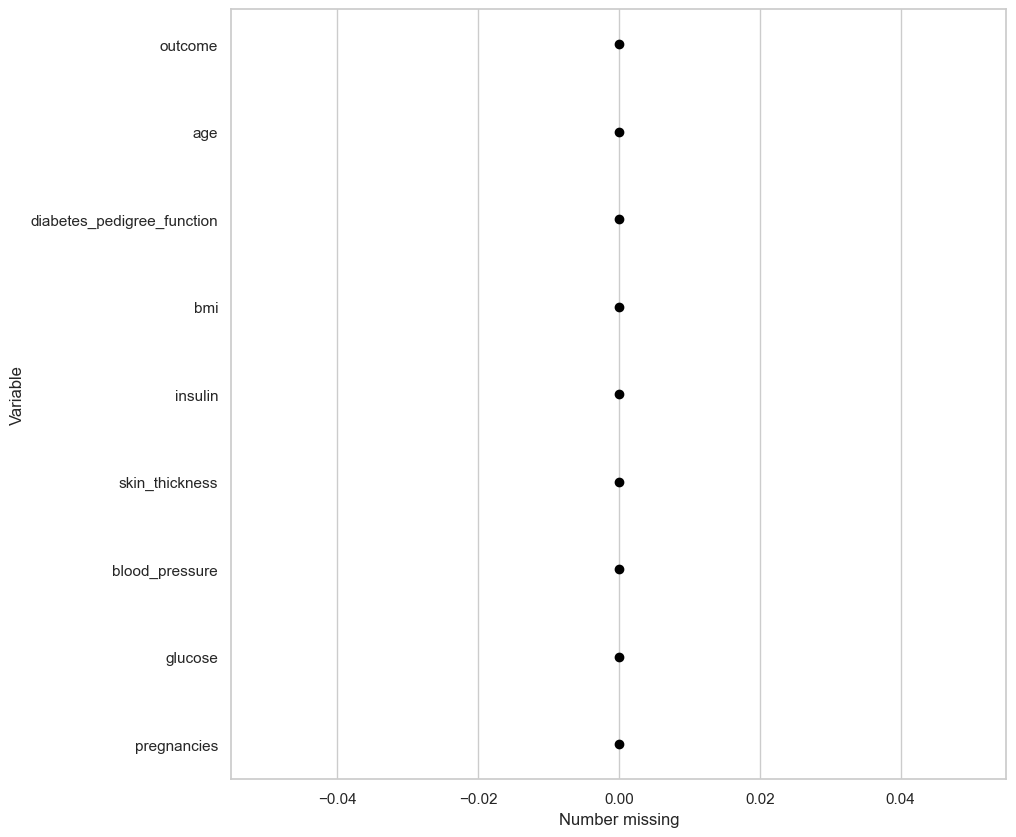

In [61]:
diabetesDf.missing.missing_variable_plot()

El gráfico nos dice que no tenemos valores faltantes pero la realidad es que los datos faltantes están enmascarados, codificados como ceros. Solucionamos el problema reemplazando los ceros con *nan*.

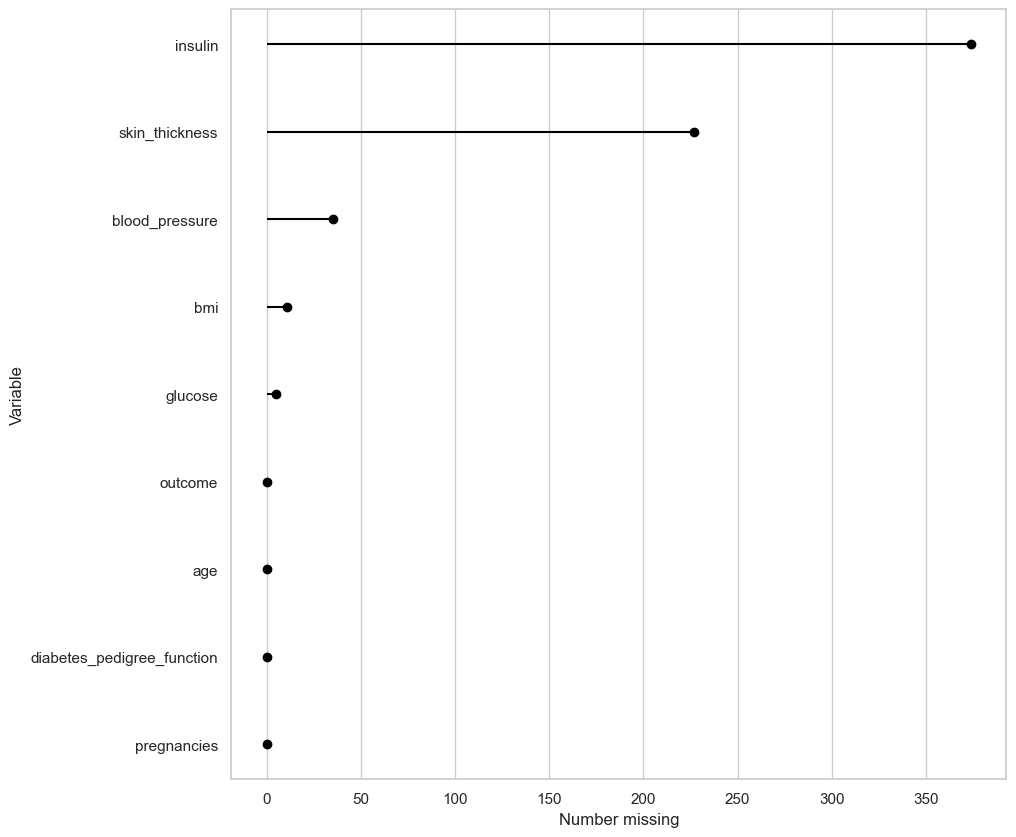

In [62]:
diabetesDf[diabetesDf.columns[1:6]] = diabetesDf[diabetesDf.columns[1:6]].replace(0, np.nan)
diabetesDf.missing.missing_variable_plot()

Ahora sí vemos los datos faltantes.

#### Missing Completely At Random (MCAR)

Utilizaremos el método *sort_variables_by_missingness()* que nos ordena las columnas respecto a su número de valores faltantes y luego utilizaremos un *pipe* para mostrar los datos como una matriz de sombra.

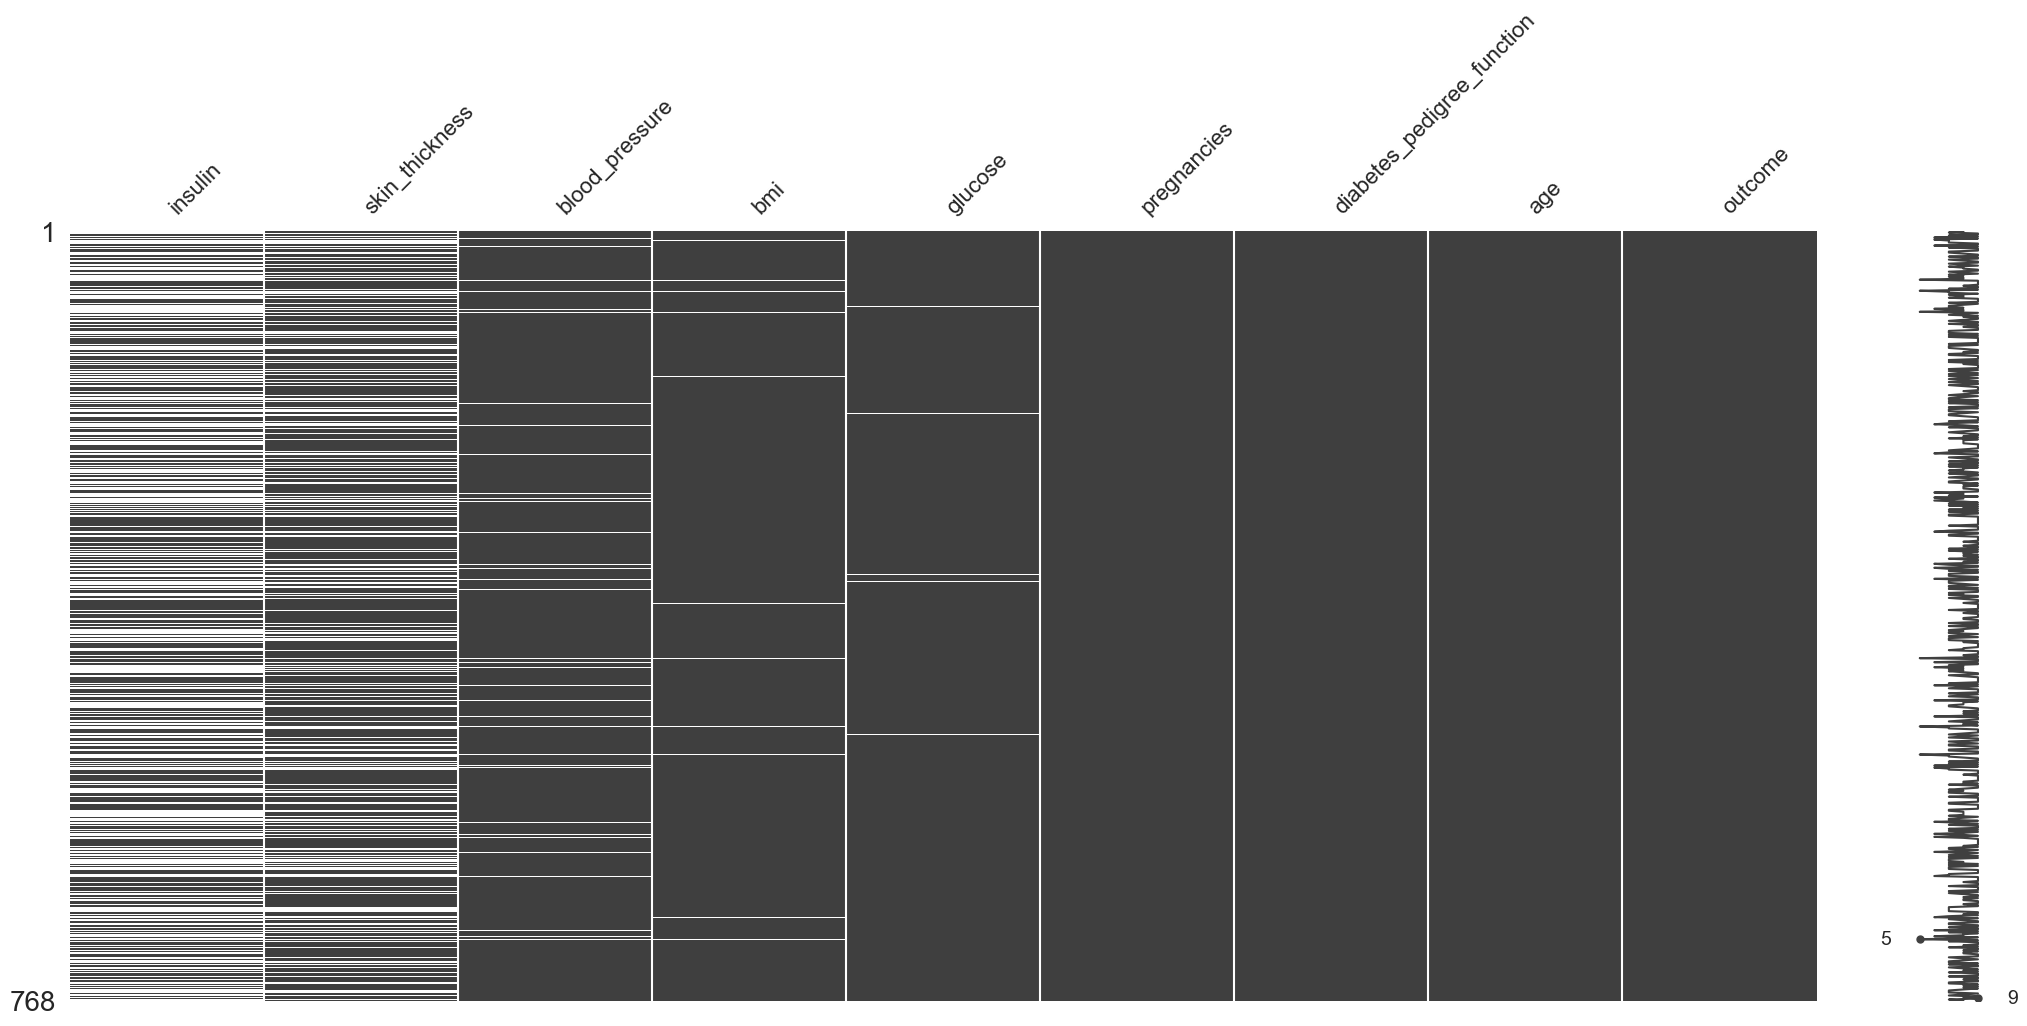

In [63]:
diabetesDf.missing.sort_variables_by_missingness().pipe(missingno.matrix)
plt.show()

Vemos que en las columnas de *insulin* y *skin_thickness* tenemos muchos valores faltantes, no obstante, para *bmi* y *glucose* no tenemos tanto. Podríamos decir que es tan poco frecuente esta aparición que podemos considerarlas como al azar. 

#### Missing At Random (MAR)

De nuevo utilizamos el método *sort_variables_by_missingness* que nos ordena las columnas respecto a su número de valores faltantes, luego usamos *sort_values* para ordenar los datos en función de una variable y finalmente utilizamos un *pipe* para mostrar los datos como una matriz de sombra.

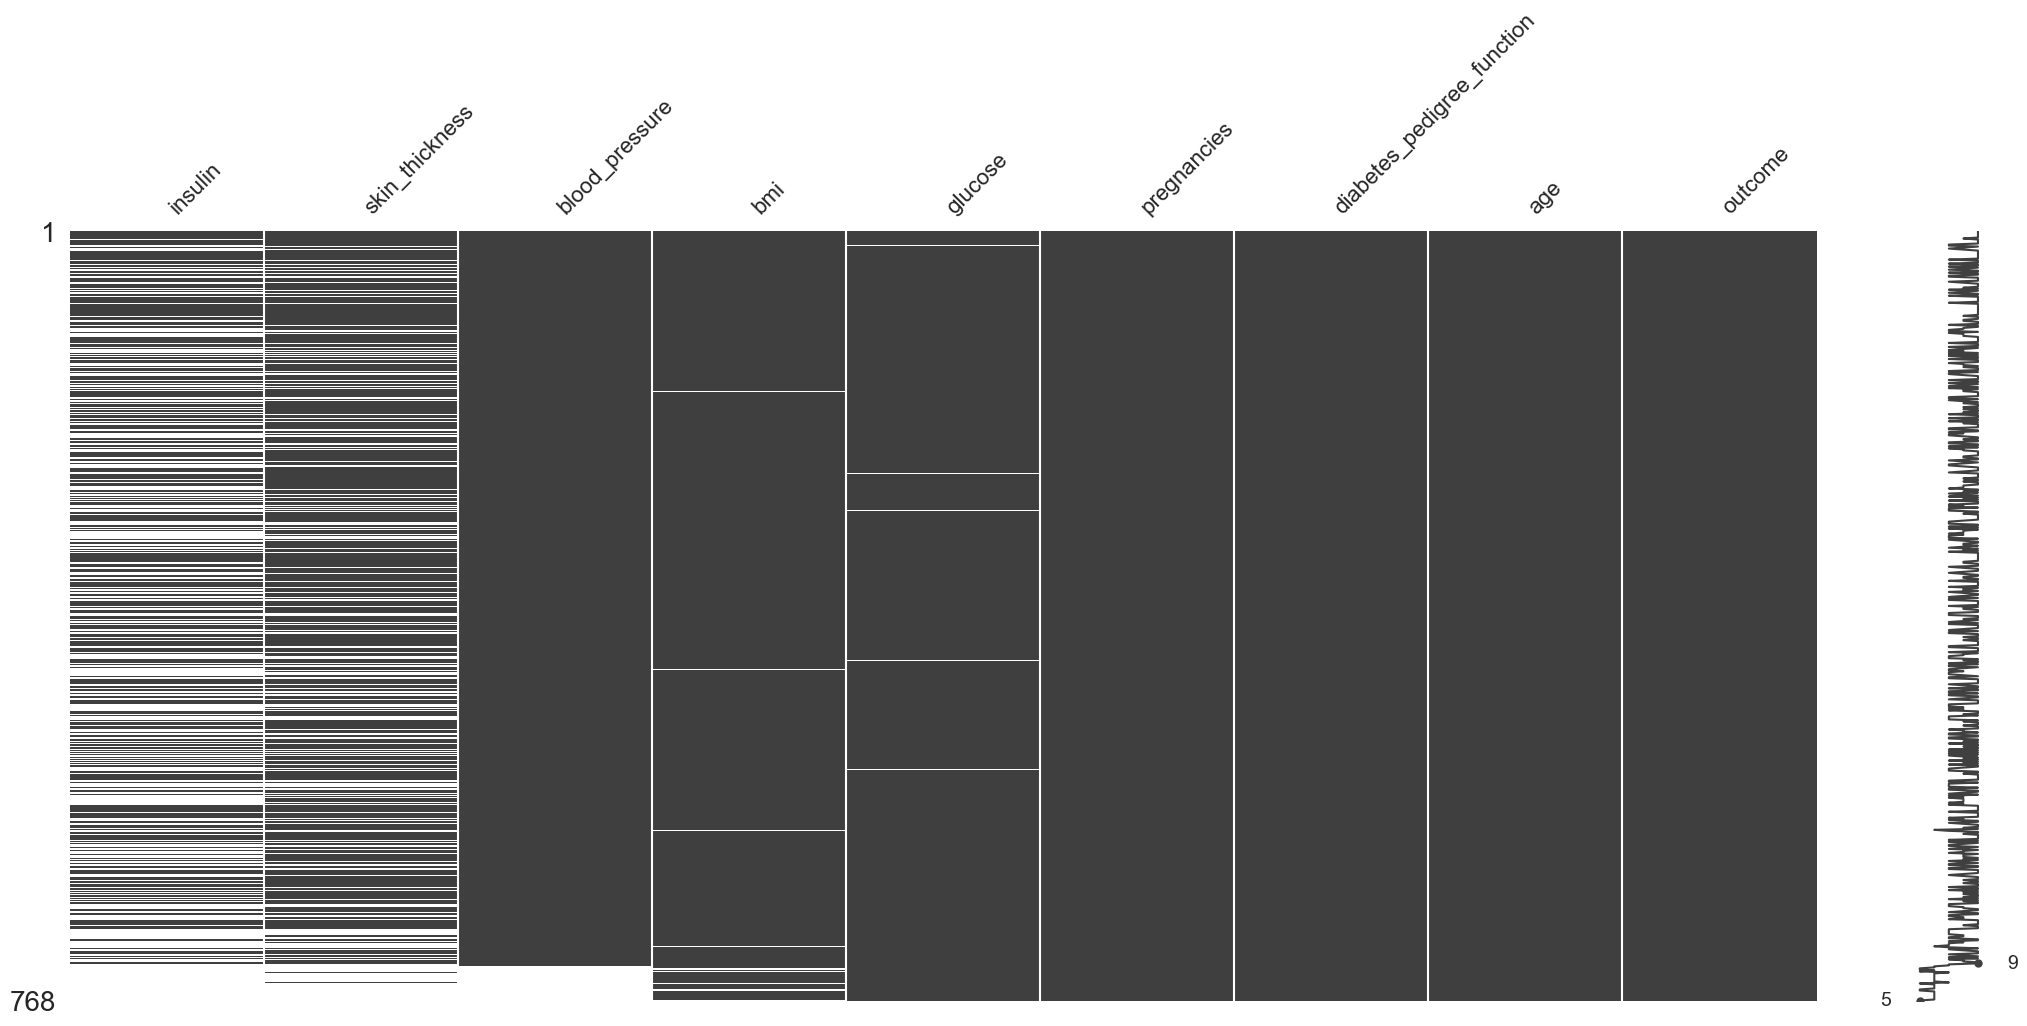

In [64]:
diabetesDf.missing.sort_variables_by_missingness().sort_values(by = "blood_pressure").pipe(missingno.matrix)
plt.show()

Podemos observar en la parte inferior de gráfico que *blood_pressure* tiene valores faltantes y que esto se repite en otras variables lo que podría indicar una relación con, por ejemplo, *insulin* y *skin_thickness*. Son datos que pueden estar perdidos al azar pero que depende de algún otro valor que estamos midiendo.

#### Missing Not At Random (MNAR)

Usamos el código anterior pero ahora ordenando por *insulin*.

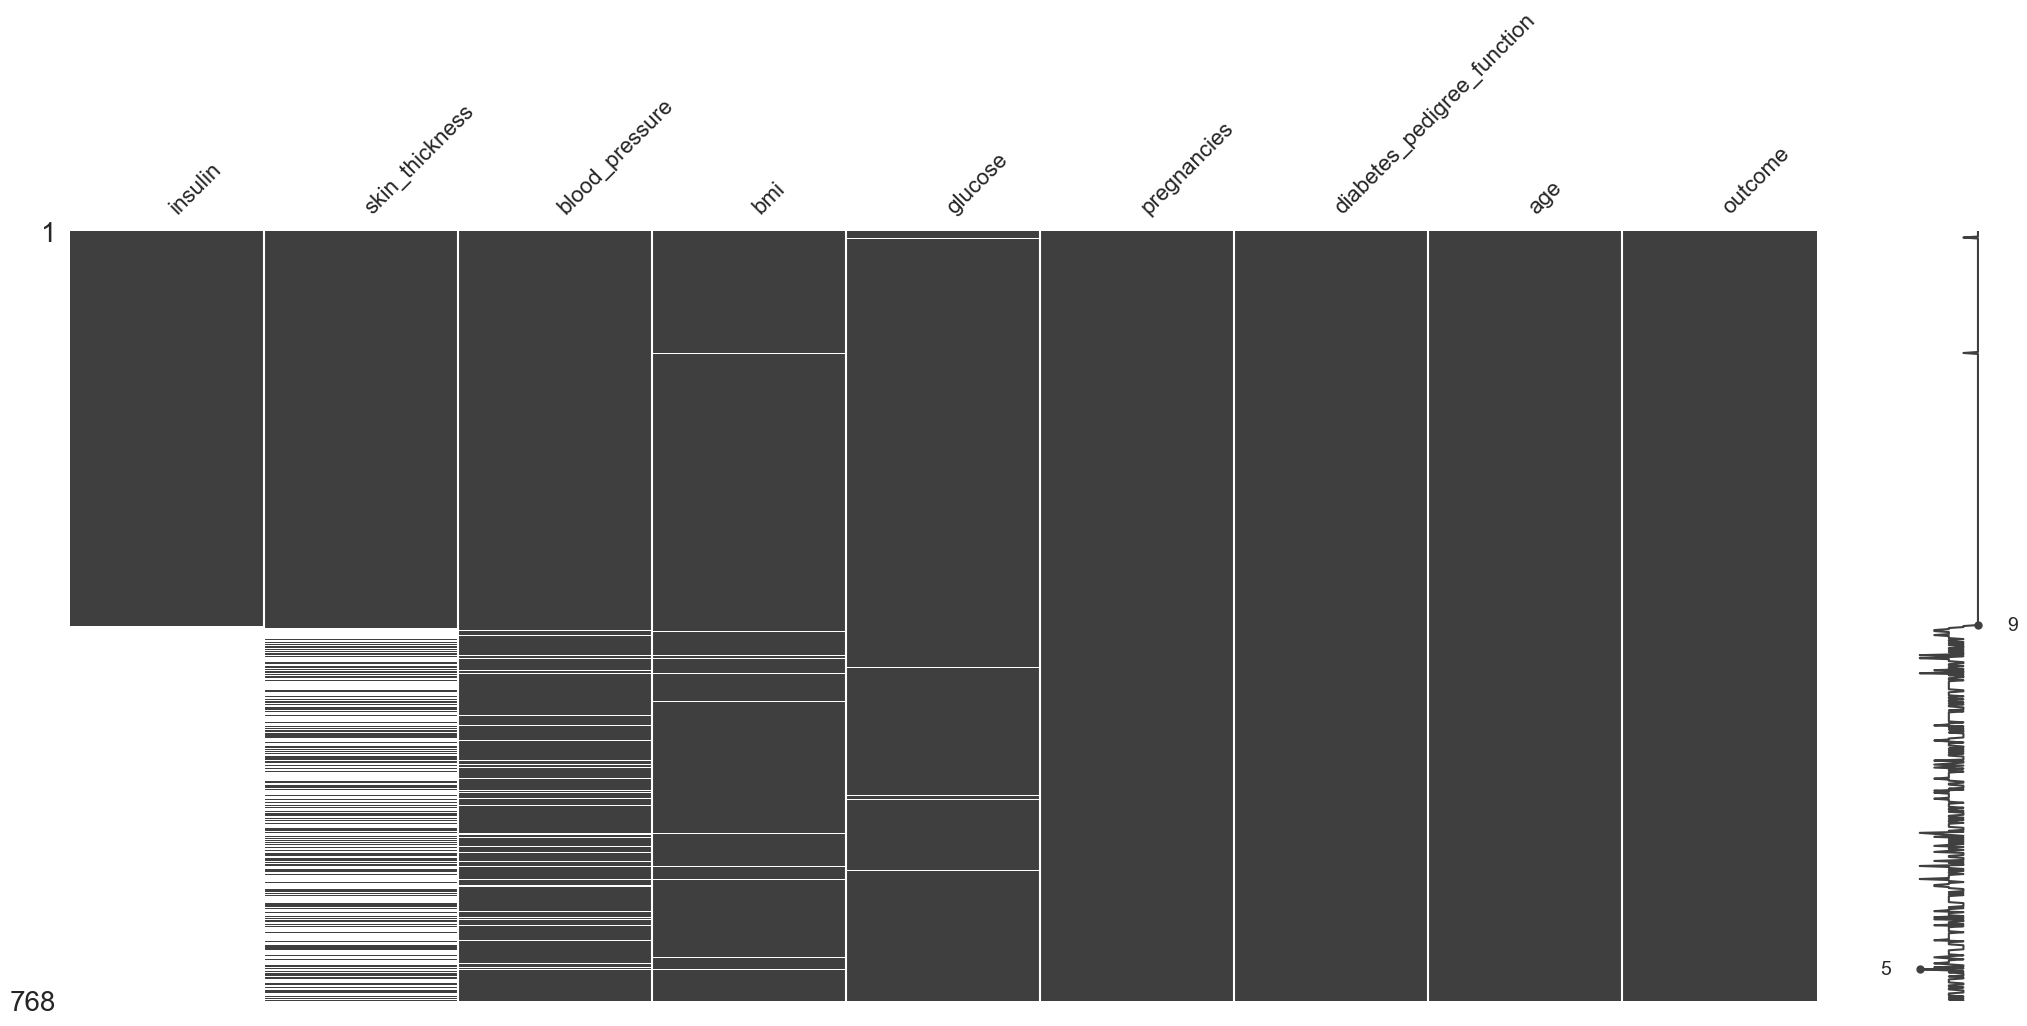

In [65]:
diabetesDf.missing.sort_variables_by_missingness().sort_values(by = "insulin").pipe(missingno.matrix)
plt.show()

Al ordenar por *insulin* vemos que todos los valores faltantes de *skin_thickness* y *blood_plessure* se agrupan en la misma sección que *insulin*; a veces hay valores, a veces no, pero la sección que siempre tiene valores faltantes es *insulin* y eso nos indica que nos están faltando esos datos por alguna razón que podría o no estar en nuestros datos.

## Búsqueda de relaciones de valores faltantes

### Matriz de sombra

La matriz de sombra permite establecer relaciones entre las variables que tienen todas sus observaciones y la ausencia o presencia de otras variables de forma que se pueda comparar estadísticos o visualizarlos de manera efectiva.

**Creación de la matriz de sombra**:
1. Identificar todos los valores faltantes .
2. Reemplazar los valores faltantes con True (1) y el resto con False (0).
3. Reemplazar los True y False por algo que sea más informativo: añadir un sufijo a los nombres de las variables.

![](matrizSombra.jpg)<br>
![](matrizSombra2.jpg)

#### Construcción de la matriz de sombra

Construimos la matriz de sombra.

In [66]:
(
    # Creamos una matriz booleana con los valores faltantes del dataframe
    riskfactorsDf.isnull()
    # Reemplazamos los valores booleanos por valores más adecuados
    .replace({
        False : "Not Missing",
        True : "Missing"
    })
    # Agregamos un sufijo a cada variable
    .add_suffix("_NA")
    # Concatenamos los valores de la matriz de sombra a la derecha del dataframe con los valores del df original
    .pipe(lambda shadow_matrix : pd.concat(
        [riskfactorsDf, shadow_matrix],
        axis = "columns"
    ))
)

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100_NA,smoke_days_NA,smoke_stop_NA,smoke_last_NA,diet_fruit_NA,diet_salad_NA,diet_potato_NA,diet_carrot_NA,diet_vegetable_NA,diet_juice_NA
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,Not Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Not Missing,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Not Missing,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing


También podemos construir la matriz de sombra usando una función personalizada.

In [67]:
riskfactorsDf.missing.bind_shadow_matrix(
    # Solo se pasan las variables con valores faltantes
    only_missing = True
)

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100_NA,smoke_days_NA,smoke_stop_NA,smoke_last_NA,diet_fruit_NA,diet_salad_NA,diet_potato_NA,diet_carrot_NA,diet_vegetable_NA,diet_juice_NA
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,Not Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Not Missing,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Not Missing,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing


#### Explorar estadísticos utilizando la matriz de sombra

Exploramos el conjunto de datos con las nuevas columnas para verificar si existen diferencias de alguna variable referente a la ausencia de otra.

In [68]:
riskfactorsDf.missing.bind_shadow_matrix(
    # Solo se pasan las variables con valores faltantes
    only_missing = True
).groupby(
    # Agrupamos por la ausencia de el peso
    ["weight_lbs_NA"]
)["age"].describe().reset_index() # Verificamos edad en función de la ausencia del peso

,weight_lbs_NA,count,mean,std,min,25%,50%,75%,max
0,Missing,10.0,60.100000,13.706851,37.0,52.25,62.5,65.0,82.0
1,Not Missing,235.0,58.021277,17.662904,7.0,47.50,59.0,70.0,97.0


### Visualización de valores faltantes en una variable

La visualización de valores faltantes en una variable permite detectar si está ocurriendo un sesgo en la presencia o ausencia de valores faltantes ocasionado por otra variable.

Comparando los valores faltantes de la variable peso con los valores de la variable edad.

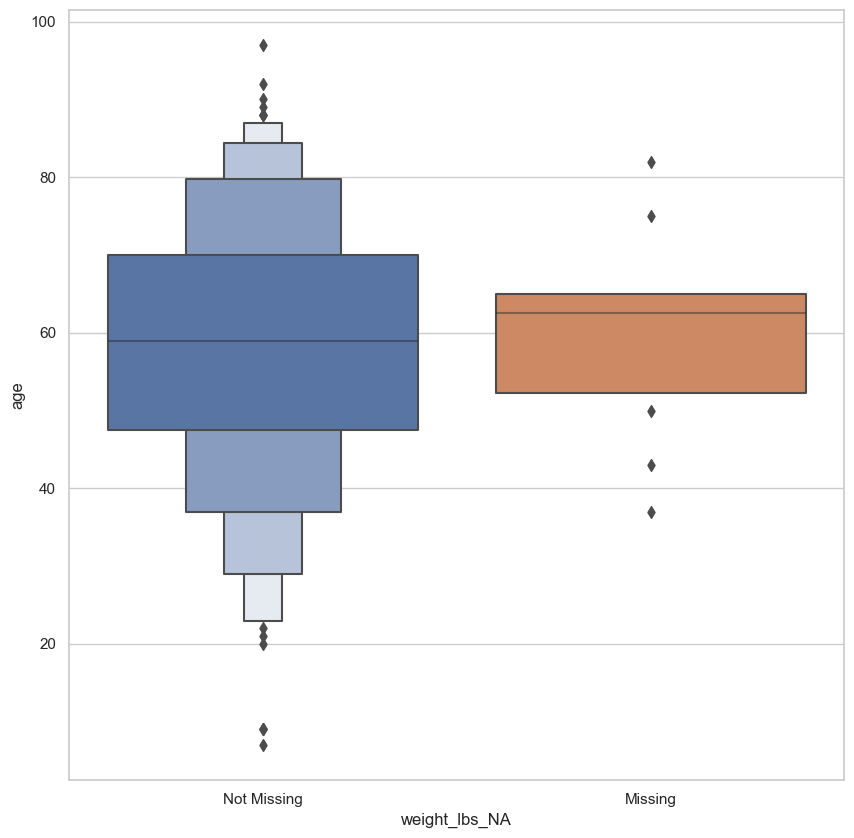

In [69]:
riskfactorsDf.missing.bind_shadow_matrix(only_missing = True).pipe(lambda df: (
    # Utilizamos Seaborn para crear una visualización parecida a un boxplot pero que muestra la concentración.
    sns.boxenplot(
        data = df,
        # Variable por la que agrupamos
        x = "weight_lbs_NA",
        # Variable que queremos ver la distribución
        y = "age"
    )
))
plt.show()

Visualización mediante la función de densidad.

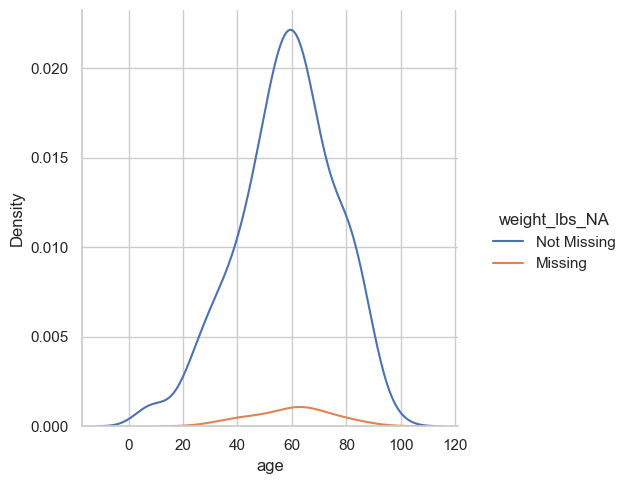

In [70]:
riskfactorsDf.missing.bind_shadow_matrix(only_missing = True).pipe(lambda df: (
    # Utilizamos Seaborn para crear una visualización kde
    sns.displot(
        data = df,
        # Variable que queremos ver la distribución
        x = "age",
        # Agrupamos por el peso
        hue = "weight_lbs_NA",
        # Función de densidad
        kind = "kde"
        
    )
))
plt.show()

Visualización mediante histogramas independientes.

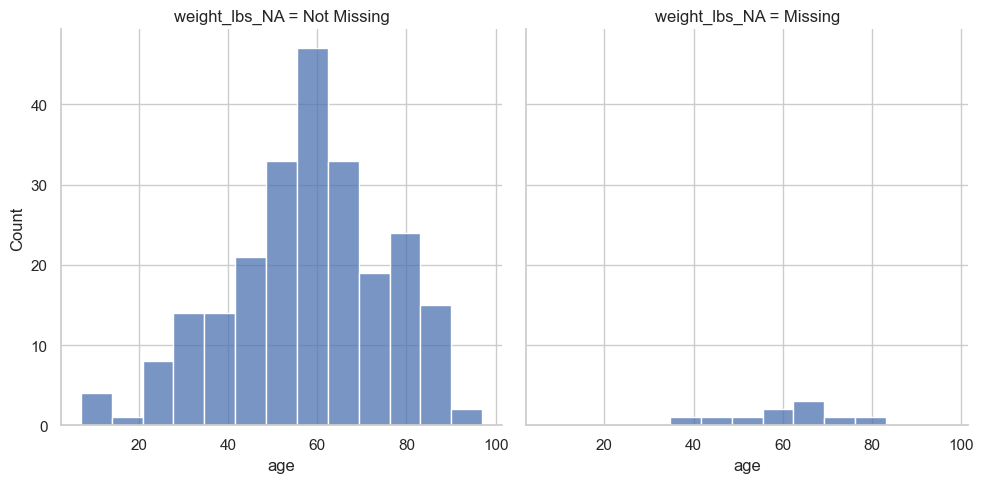

In [71]:
riskfactorsDf.missing.bind_shadow_matrix(only_missing = True).pipe(lambda df: (
    # 
    sns.displot(
        data = df,
        # Variable que queremos ver la distribución
        x = "age",
        # Agrupamos por el peso
        col = "weight_lbs_NA"
    )
))
plt.show()

Podemos hacer que los ejes Y sean independientes para cada gráfico y así visualizar mejor la distribución.

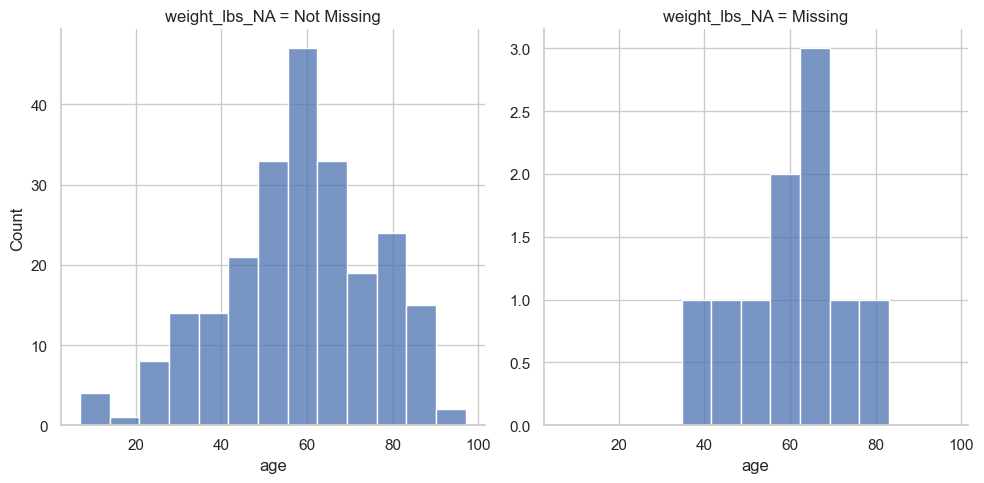

In [72]:
riskfactorsDf.missing.bind_shadow_matrix(only_missing = True).pipe(lambda df: (
    # 
    sns.displot(
        data = df,
        # Variable que queremos ver la distribución
        x = "age",
        # Agrupamos por el peso
        col = "weight_lbs_NA",
        # Indicamos que cada eje Y tenga su escala
        facet_kws = {"sharey" : False}
    )
))
plt.show()

### Visualización de valores faltantes en dos variables

In [73]:
# Funcioó que añade valores aleatorios a las variables con valores faltantes para visualizarlos en un eje
def column_fill_with_dummies(
    column: pd.Series,
    proportion_below: float = 0.10, # Proporción de los datos en la gráfica 
    jitter: float = 0.075,  # evita el asolapamiento de los puntos en la gráfica
    seed: int = 42, # semilla para la aleatoriedad
) -> pd.Series: # la función retorna una serie

    #Copiar las columnas del dataframe
    column = column.copy(deep = True)

    #Extraer los valores de las variables
    missing_mask = column.isna() # matriz de booleanos
    number_missing_values = missing_mask.sum() # conteo de valores faltantes
    column_range = column.max() - column.min() # rango de las variables

    # shift data
    column_shift = column.min() - column.min() * proportion_below

    # crear un poco de ruido alrededor de los puntos 
    np.random.seed(seed)
    column_jitter = (np.random.rand(number_missing_values) - 2) * column_range * jitter

    #Guardar los nuevos datos aleatorios
    column[missing_mask] = column_shift + column_jitter

    return column

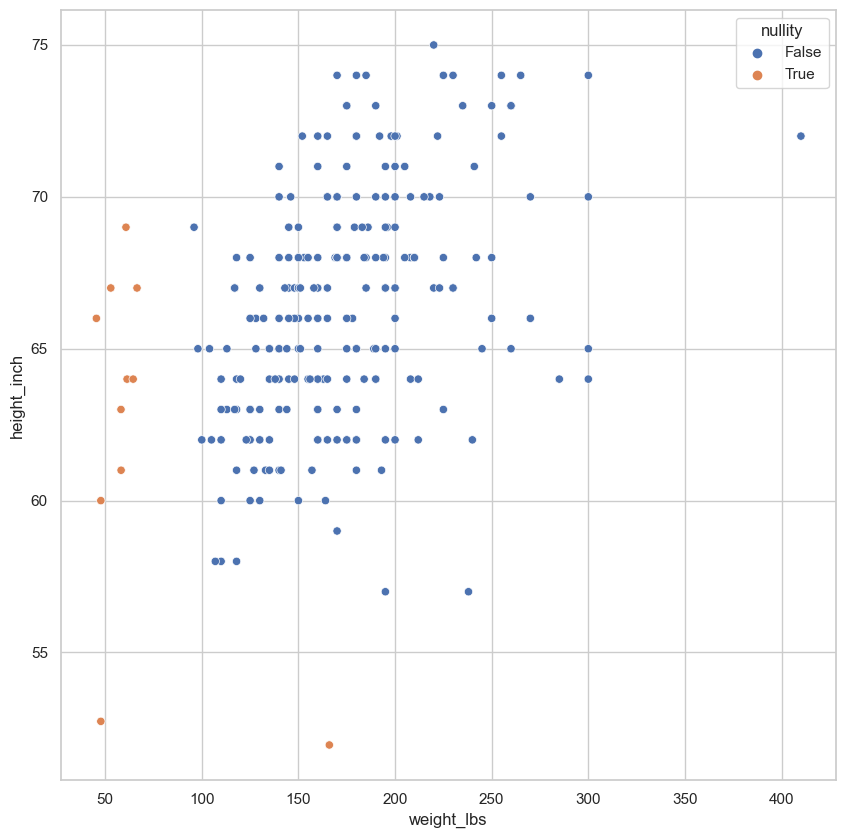

In [75]:
(
    riskfactorsDf
    .select_dtypes(
        exclude='category'  # excluye las variables categóricas
    )
    .pipe(
        lambda df: df[df.columns[df.isna().any()]] # seleccionar solo columnas que tengan valores faltantes
    )
    .missing.bind_shadow_matrix(true_string = True, false_string = False)
    .apply(
        lambda column: column if '_NA' in column.name else column_fill_with_dummies(column, proportion_below=0.05, jitter=0.075)
    )
    .assign(
        nullity = lambda df: df.weight_lbs_NA | df.height_inch_NA
    )
    .pipe(
        lambda df: (
            sns.scatterplot(
                data = df,
                x='weight_lbs',
                y= 'height_inch',
                hue='nullity'
            )
        )
    )
)
plt.show()

### Correlación de nulidad

La correlación de nulidad nos ayuda para saber si existen valores faltantes que aparecen conjuntamente con otras variables del conjunto de datos.

#### Mapa de calor

Utilizando la función *heatmap* de *missingno* podemos ver las correlaciones de nulidad entre las variables del conjunto de datos.

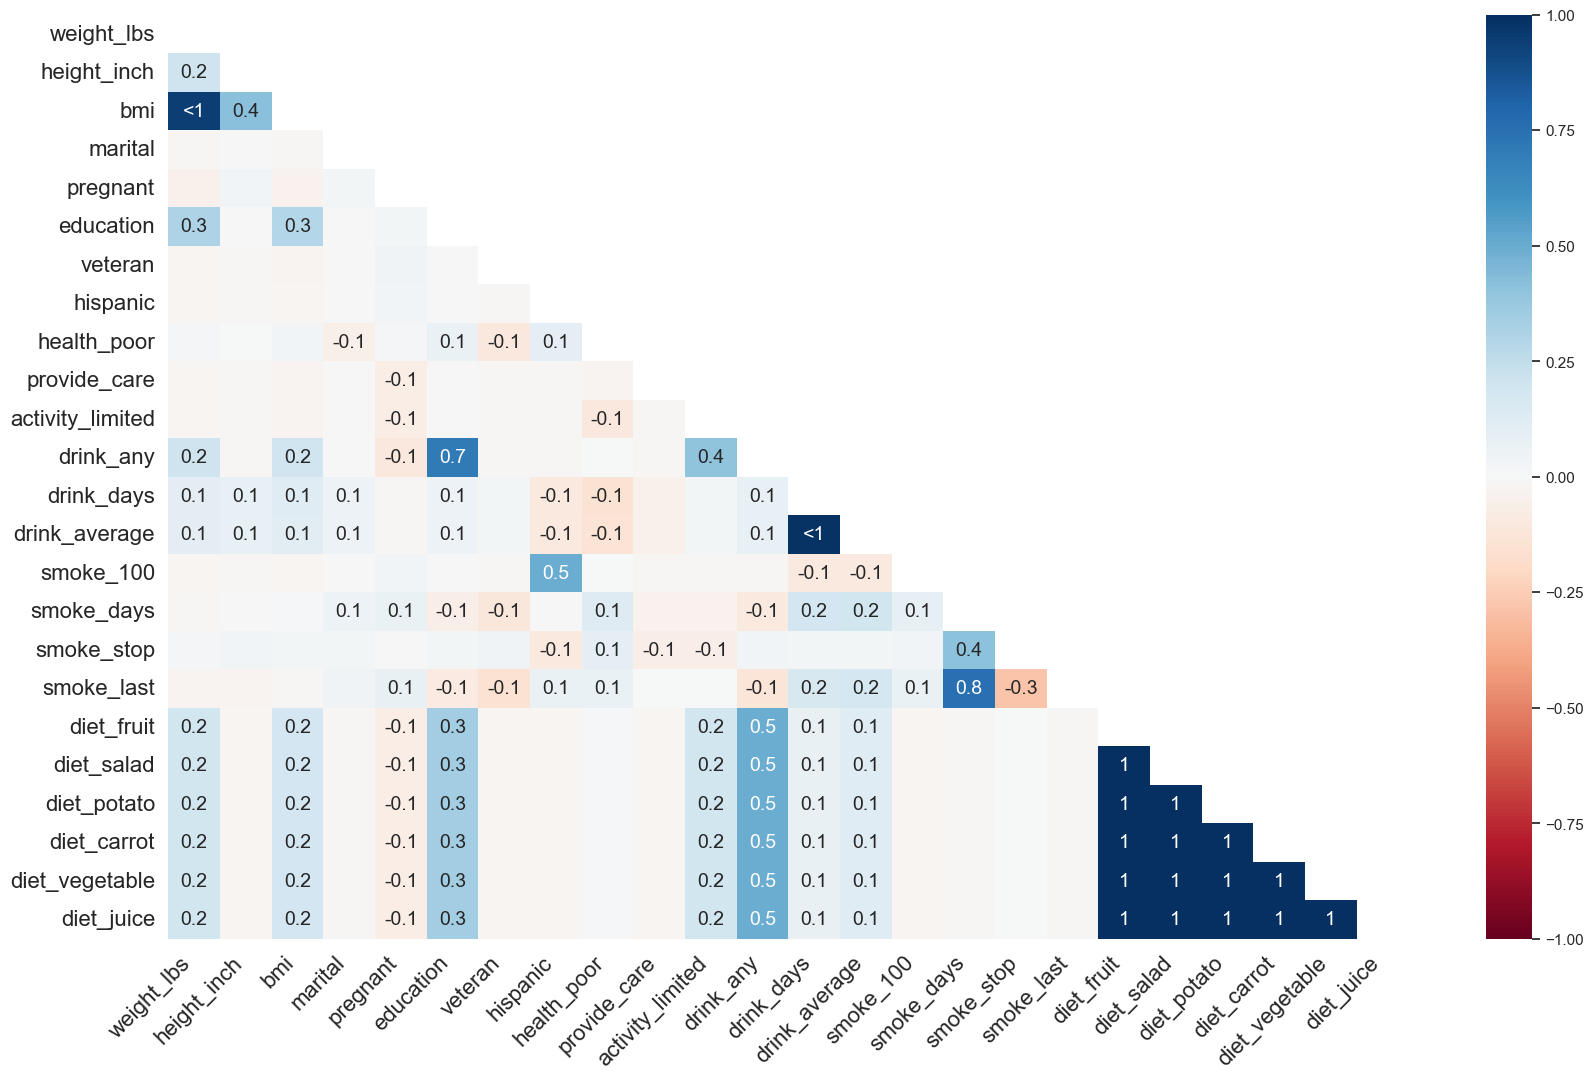

In [76]:
missingno.heatmap(
    df = riskfactorsDf
)
plt.show()

El color azul representa una correlación positiva, es decir, la presencia de un valor faltante en una variable está correlacionada con la presencia de un valor faltante en otra variable. Por ejemplo, cada que falta un valor en la dieta de fruta falta un valor en la dieta de ensalada.

El color rojo representa una correlación negativa, es decir, si hay un valor faltante en una variable entonces en la otra variable habrá un valor completo y visceversa.

#### Dendograma

Se trata de un clustering jerárquico que agrupa las variables con correlaciones muy altas.

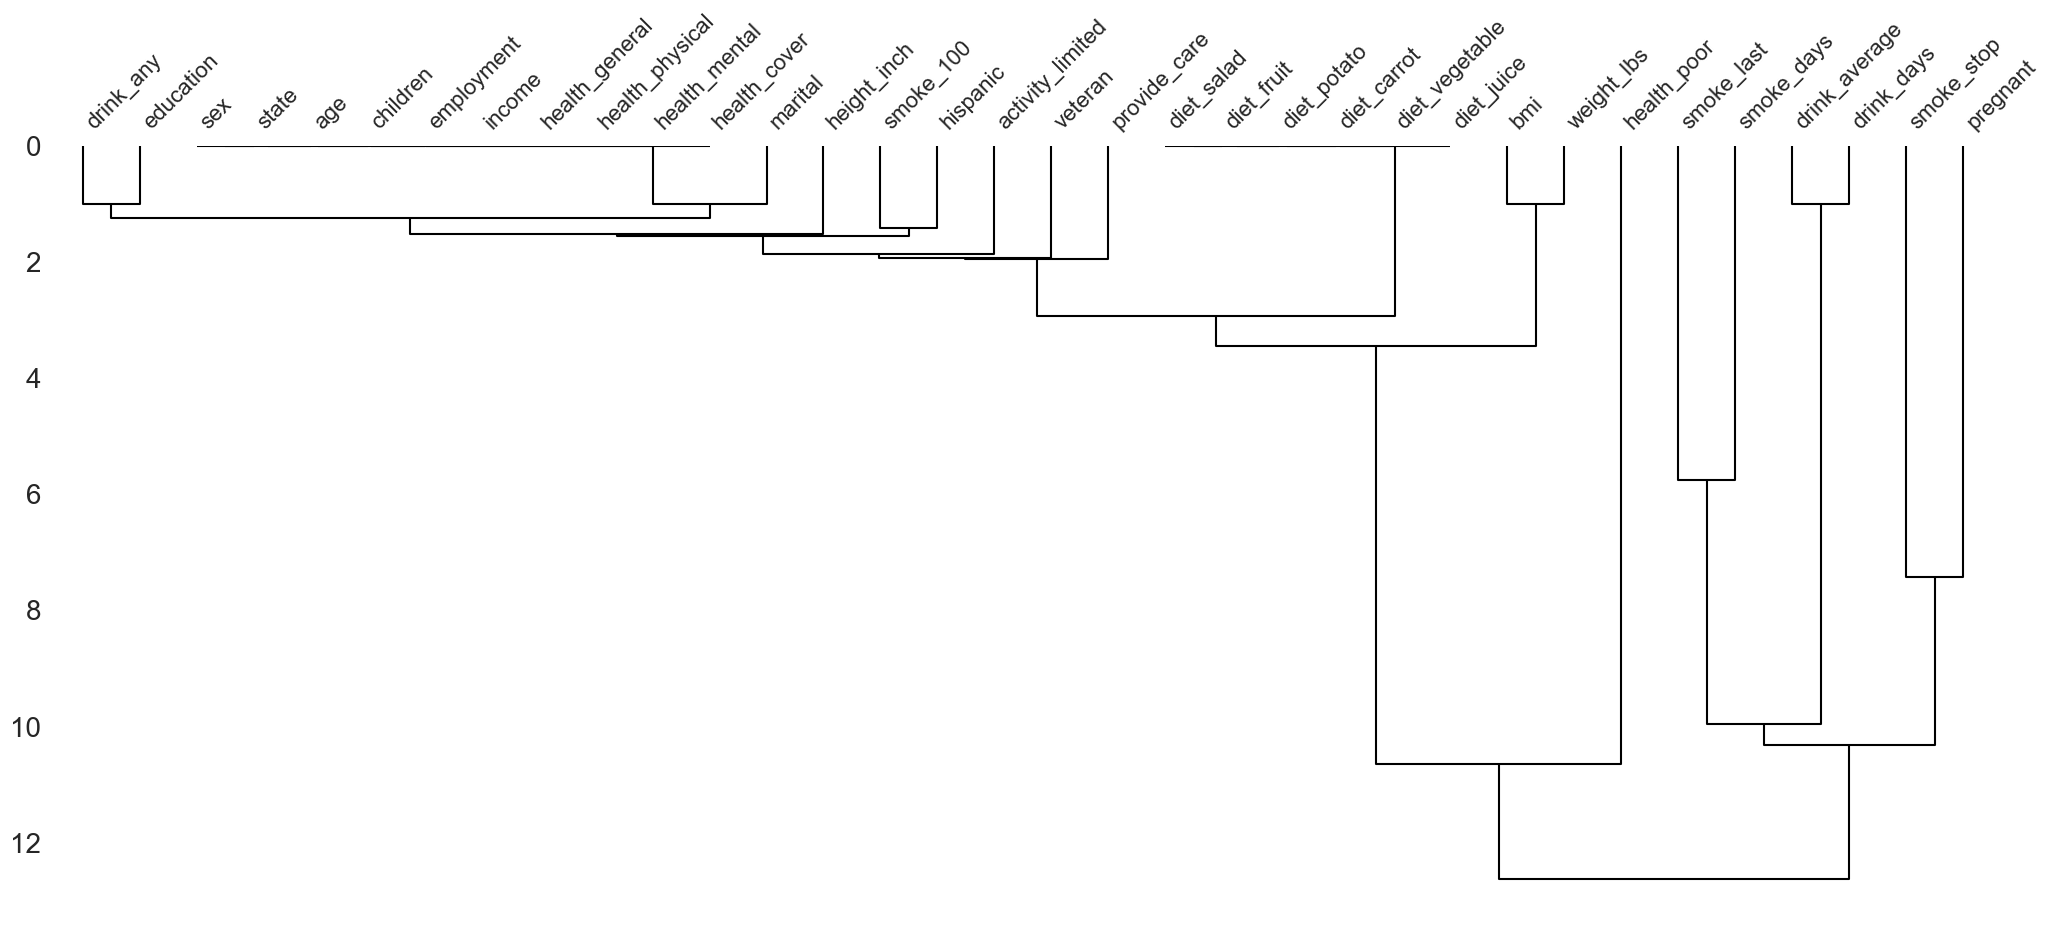

In [78]:
missingno.dendrogram(
    df = riskfactorsDf
)
plt.show()

Las variables que están agrupadas cerca del nivel base (0) indican una alta correlación y entre más separadas estén de la base menos correlación habrá. Por ejemplo, para todo el grupo de las dietas hay una línea recta en la base y eso nos indica que están muy correlacionadas.

## Tratamiento de valores faltantes

### Eliminación de valores faltantes

La eliminación de valores faltantes asume que los valores faltantes están perdidos completamente al azar (MCAR). En cualquier otro caso, realizar una eliminación de valores faltantes podrá ocasionar sesgos en los análisis y modelos subsecuentes.

Primero observamos el número total de observaciones y variables en el conjunto de datos.

In [79]:
riskfactorsDf.shape

(245, 34)

#### Pairwise deletion (eliminación por pares)

Solo se eliminan los valores faltantes durante los cálculos de ciertas funciones. Pandas por defecto ignora los registros con datos faltantes a la hora de hacer cálculos.

In [82]:
# Vemos que tenemos valores faltantes
riskfactorsDf.weight_lbs.isnull().sum()

10

In [83]:
# Hacemos el cálculo del promedio
riskfactorsDf.weight_lbs.mean()

174.26808510638298

In [84]:
# Tamaño del dataframe, conteo de los valores del dataframe
riskfactorsDf.weight_lbs.size, riskfactorsDf.weight_lbs.count()

(245, 235)

Pandas ya ignora estos valores faltantes.

In [86]:
riskfactorsDf.weight_lbs.mean(skipna = False)

nan

#### Listwise Deletion or Complete Case (Eliminación por lista o caso completo)

Si existen un valor faltante entonces toda la fila es eliminada.

##### Con base a 1 columna

In [88]:
# Utilizamos la función dropna para "soltar" los valores faltantes
riskfactorsDf.dropna(
    # Lista de variables donde buscar los valores faltantes
    subset = ["weight_lbs"],
    # any indica que se elimine cualquier registro que tenga al menos un valor faltante
    how = "any"
).shape

(235, 34)

Se eliminaron 10 observaciones.

##### Con base a 2 columnas o más 


**Utilizando any**

In [89]:
# Utilizamos la función dropna para "soltar" los valores faltantes
riskfactorsDf.dropna(
    # Lista de variables donde buscar los valores faltantes
    subset = ["weight_lbs", "height_inch"],
    # any indica que se elimine cualquier registro que tenga al menos un valor faltante para cualquiera de las dos variables
    how = "any"
).shape

(234, 34)

**Representación visual**

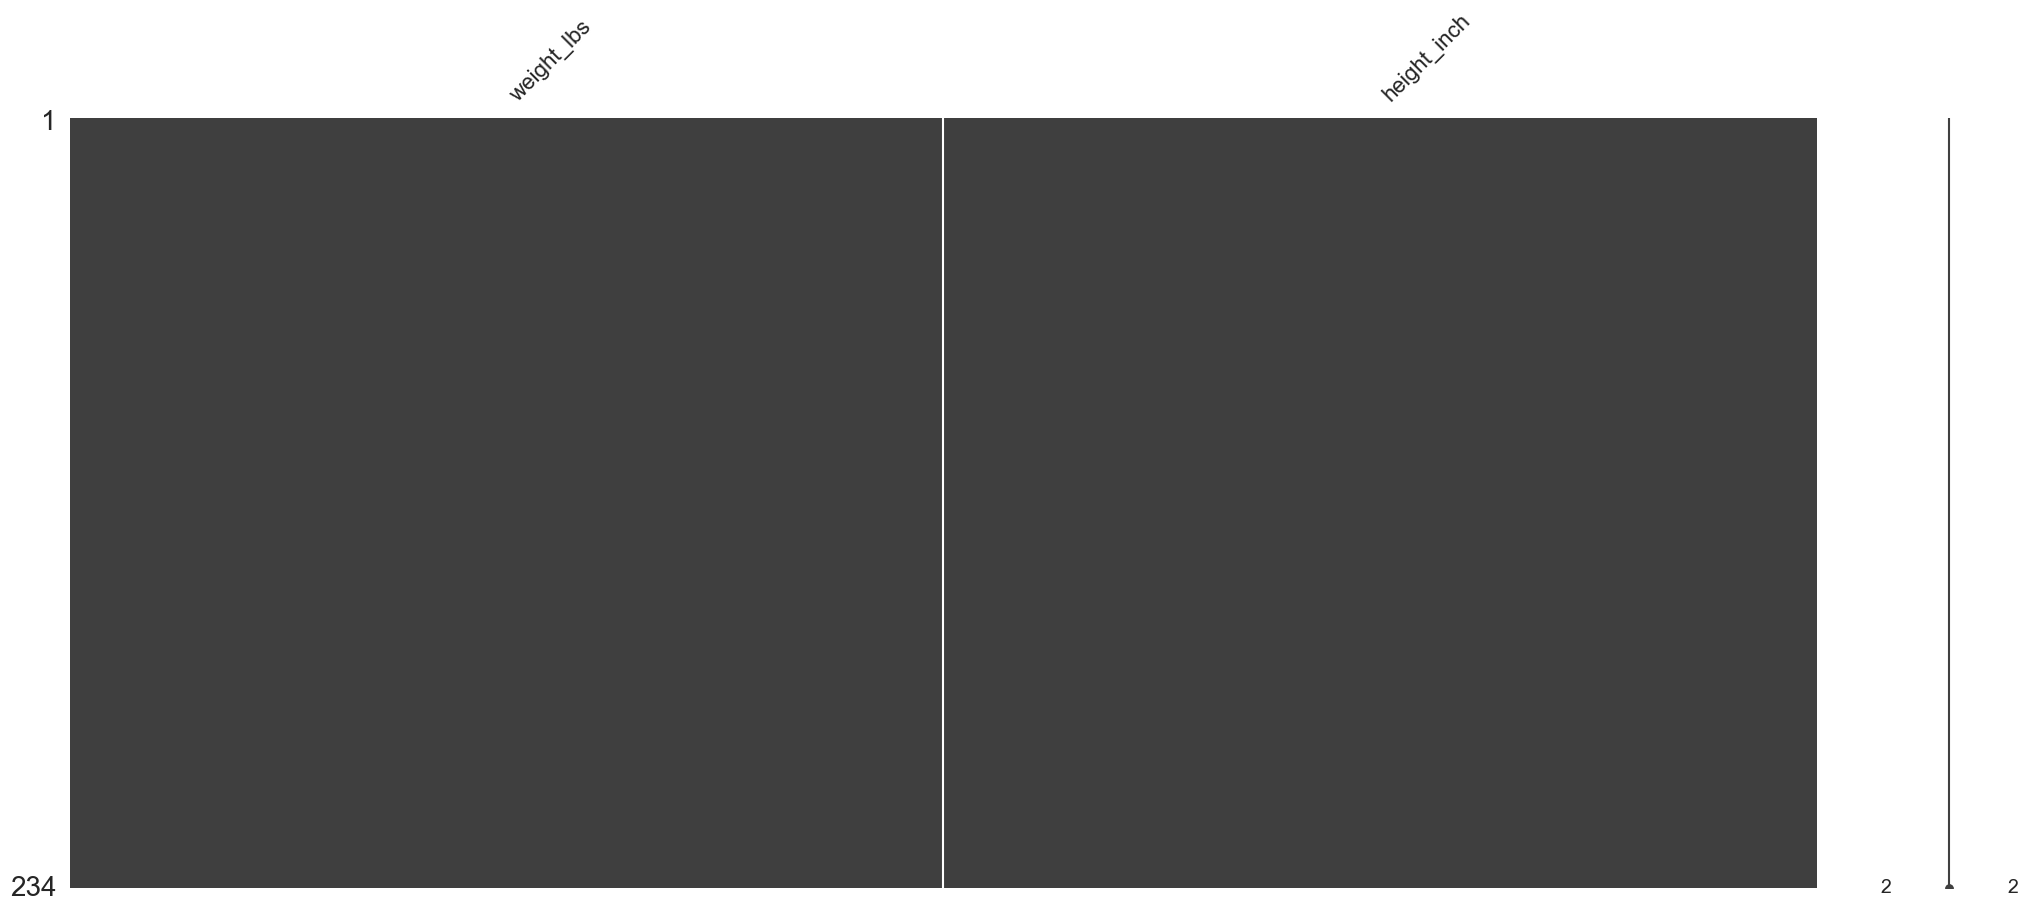

In [92]:
riskfactorsDf.dropna(
        subset = ["weight_lbs", "height_inch"],
        how = "any"
    ).select_columns(["weight_lbs", "height_inch"]).pipe(
        lambda df: missingno.matrix(df)
    )
plt.show()

**Utilizando all**

In [90]:
# Utilizamos la función dropna para "soltar" los valores faltantes
riskfactorsDf.dropna(
    # Lista de variables donde buscar los valores faltantes
    subset = ["weight_lbs", "height_inch"],
    # all indica que se eliminan los registros que tienen valores faltantes para ambas variables
    how = "all"
).shape

(244, 34)

**Representación visual**

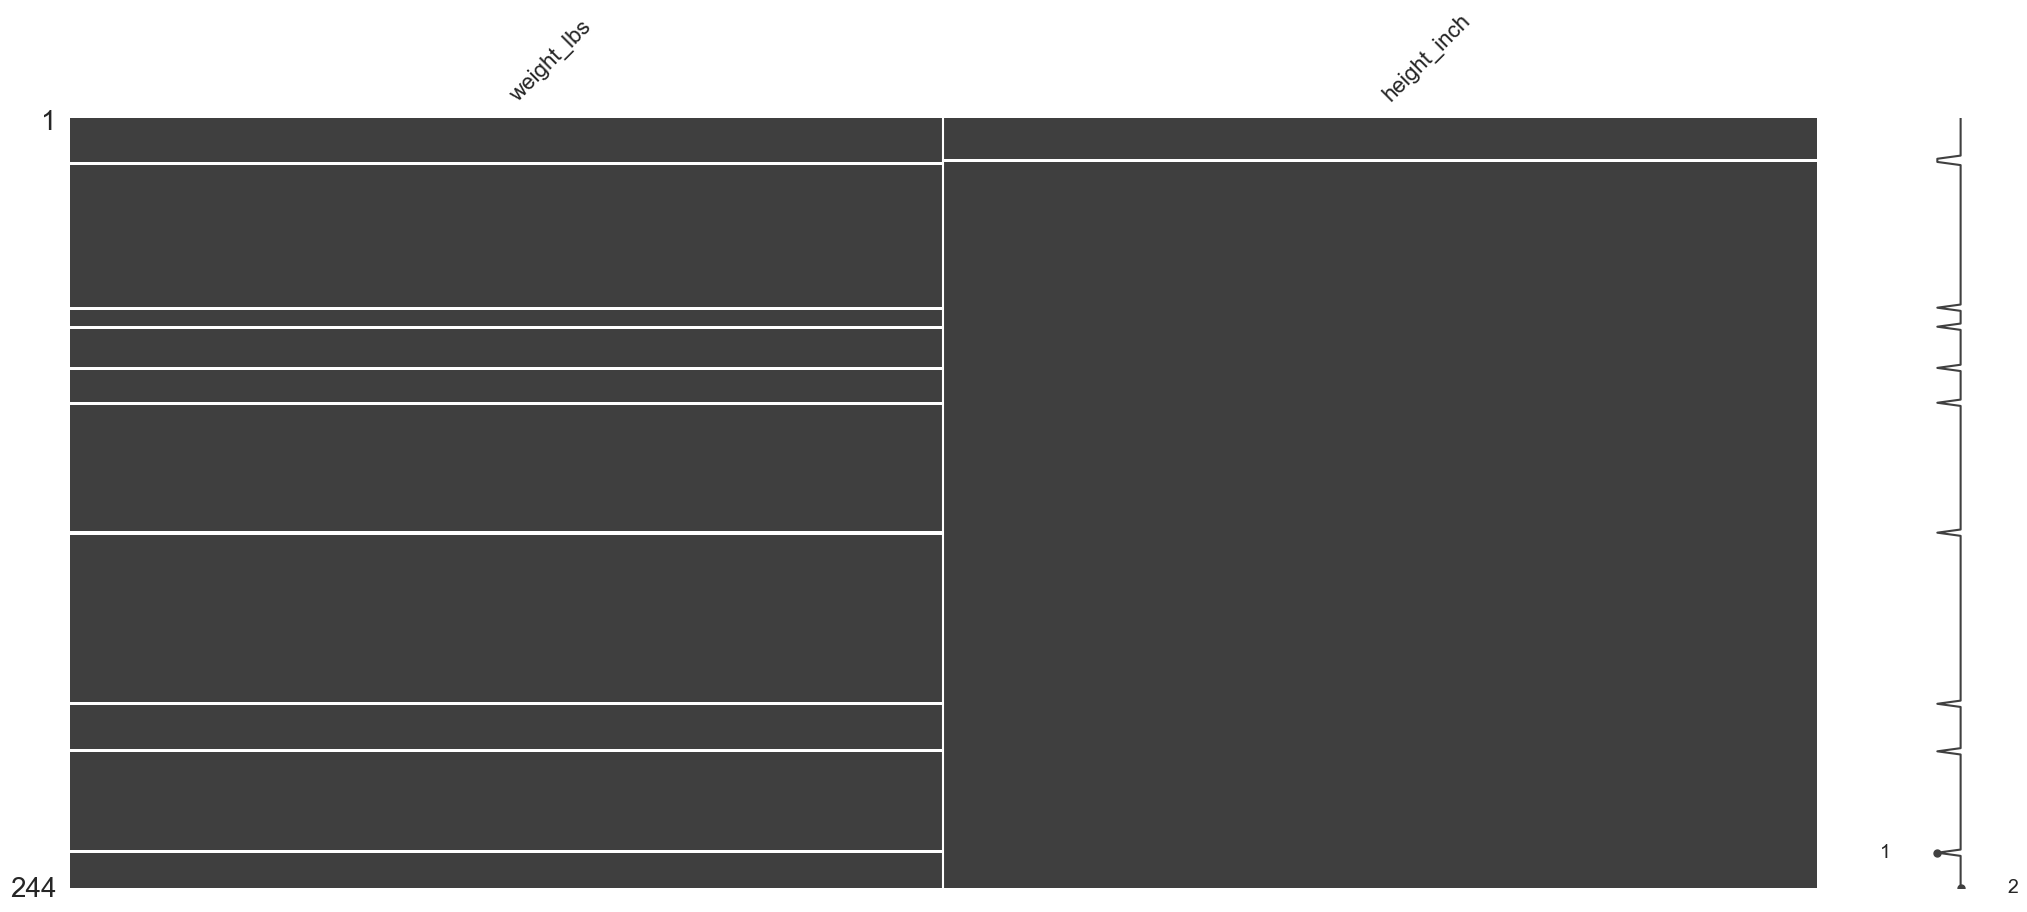

In [93]:
riskfactorsDf.dropna(
        subset = ["weight_lbs", "height_inch"],
        how = "all"
    ).select_columns(["weight_lbs", "height_inch"]).pipe(
        lambda df: missingno.matrix(df)
    )
plt.show()

### Imputación básica de valores faltantes

La imputación consiste en reemplazar los datos faltantes por algún valor, ya sea estadístico, por contexto u obtenido a través de modelos de machine learning.

#### Imputación con base en el contexto

Implica saber algo sobre la estructura de los datos y por lo tanto podemos completar las entradas vacías.

In [94]:
implicitToExplicitDf = pd.DataFrame(
    data={
        "name": ["lynn", np.nan, "zelda", np.nan, "shadowsong", np.nan],
        "time": ["morning", "afternoon", "morning", "afternoon", "morning", "afternoon",],
        "value": [350, 310, 320, 350, 310, 320]
    }
)
implicitToExplicitDf

,name,time,value
0,lynn,morning,350
1,NaN,afternoon,310
2,zelda,morning,320
3,NaN,afternoon,350
4,shadowsong,morning,310
5,NaN,afternoon,320


Podemos ver que hay valores faltantes en la columna *name* y es fácil deducir cuáles son los valores que están faltando para dicha variable. Donde están los valores faltantes debería ir el valor de la fila de arriba y podemos hacer esto mediante *ffill*.

In [95]:
implicitToExplicitDf.ffill()

,name,time,value
0,lynn,morning,350
1,lynn,afternoon,310
2,zelda,morning,320
3,zelda,afternoon,350
4,shadowsong,morning,310
5,shadowsong,afternoon,320


#### Imputación de un único valor

Cuando el contexto no es suficiente entonces requerimos de utilizar algún estadístico para la imputación de los valores faltantes.

In [96]:
riskfactorsDf.select_columns(
    # Seleccionamos las columnas que queremos hacerles la imputación
    "weight_lbs", "height_inch", "bmi"
    # Creamos una matriz de sombra con valores booleanos
    ).missing.bind_shadow_matrix(
    true_string = True, 
    false_string = False
    # Rellenamos las columnas con la media de la variable
    ).apply(
        axis = 'rows',
        func = lambda column: column.fillna(column.mean()) if '_NA' not in column.name else column
    )

,weight_lbs,height_inch,bmi,weight_lbs_NA,height_inch_NA,bmi_NA
0,190.0,64.0,32.68,False,False,False
1,170.0,68.0,25.90,False,False,False
2,163.0,64.0,28.04,False,False,False
3,230.0,74.0,29.59,False,False,False
4,135.0,62.0,24.74,False,False,False
...,...,...,...,...,...,...
240,144.0,63.0,25.56,False,False,False
241,170.0,74.0,21.87,False,False,False
242,175.0,71.0,24.46,False,False,False
243,138.0,64.0,23.74,False,False,False


Ahora podemos graficar los datos para ver cómo lucen después de la imputación.

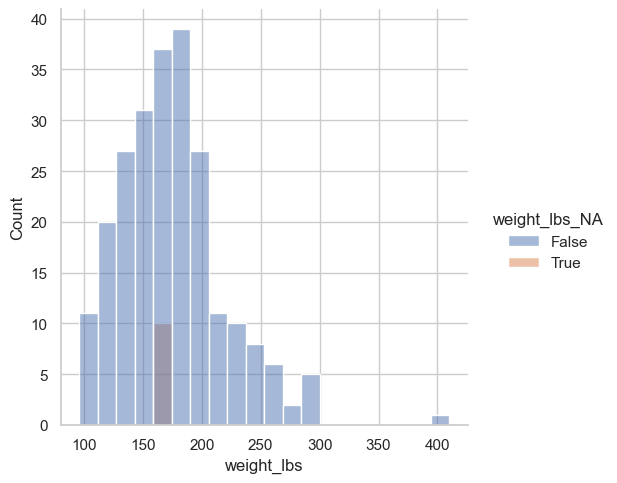

In [97]:
riskfactorsDf.select_columns(
    # Seleccionamos las columnas que queremos hacerles la imputación
    "weight_lbs", "height_inch", "bmi"
    # Creamos una matriz de sombra con valores booleanos
    ).missing.bind_shadow_matrix(
    true_string = True, 
    false_string = False
    # Rellenamos las columnas con la media de la variable
    ).apply(
        axis = 'rows',
        func = lambda column: column.fillna(column.mean()) if '_NA' not in column.name else column
    ).pipe(
        lambda df: (
            # Hacemos la gráfica
            sns.displot(
                data = df,
                x = "weight_lbs",
                hue = "weight_lbs_NA"
            )
        )
    )
plt.show()

En azul están los valores que teníamos y los naranjas son los que imputamos; como vemos, están en el promedio.

Ahora vamos a visualizar en un scatterplot dos variables.

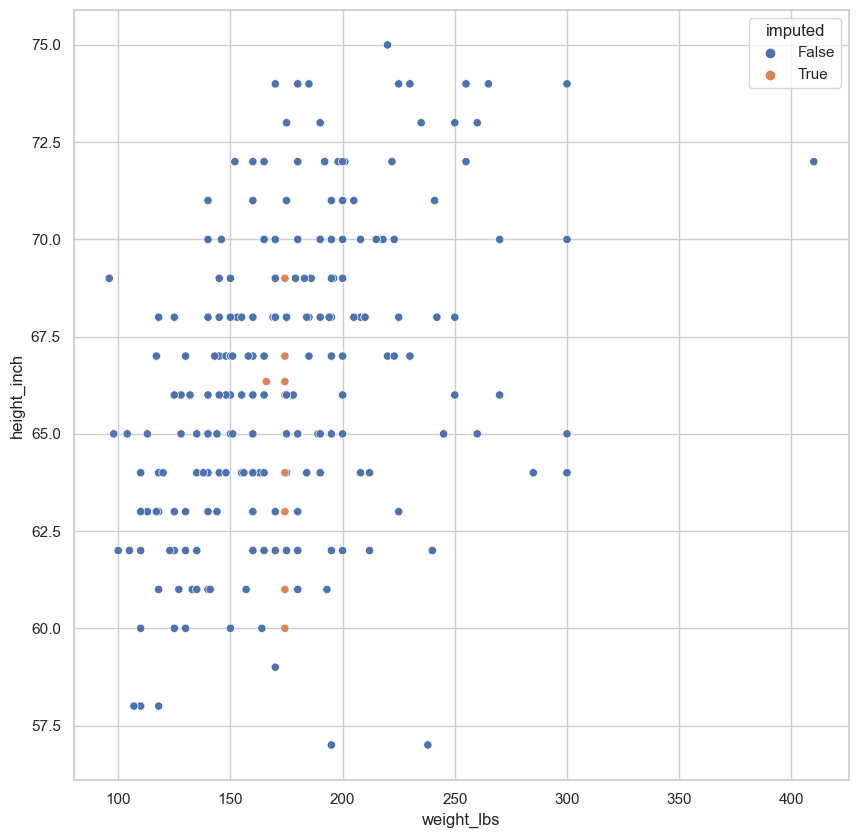

In [99]:
riskfactorsDf.select_columns(
    # Seleccionamos las columnas que queremos hacerles la imputación
    "weight_lbs", "height_inch", "bmi"
    # Creamos una matriz de sombra con valores booleanos
    ).missing.bind_shadow_matrix(
    true_string = True, 
    false_string = False
    # Rellenamos las columnas con la media de la variable
    ).apply(
        axis = 'rows',
        func = lambda column: column.fillna(column.mean()) if '_NA' not in column.name else column
    ).assign(
        # Creamos una nueva columna que nos indique si el dato ha sido imputado o no
        imputed = lambda df: df.weight_lbs_NA | df.height_inch_NA
    ).pipe(
        lambda df: (
            # Hacemos la gráfica
            sns.scatterplot(
                data = df,
                x = "weight_lbs",
                y = "height_inch",
                hue = "imputed"
            )
        )
    )
plt.show()

Los valores azules son los originales y los naranjas son los imputados.

**Visualización múltiple de imputaciones**

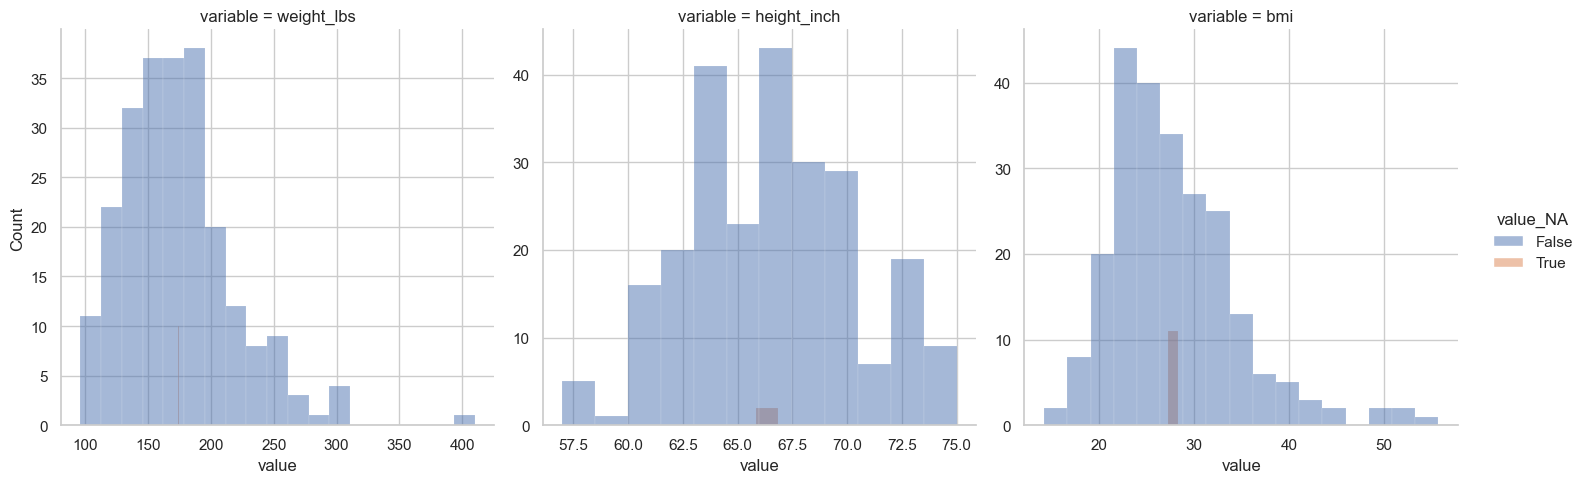

In [100]:
(
    riskfactorsDf
    .select_columns("weight_lbs", "height_inch", "bmi")
    .missing.bind_shadow_matrix(true_string = True, false_string = False)
    .apply(
        axis = "rows",
        func = lambda column: column.fillna(column.mean())
        if "_NA" not in column.name
        else column,
    )
    .pivot_longer(
        index = "*_NA"
    )
    .pivot_longer(
        index = ["variable", 'value'],
        names_to = "variable_NA",
        values_to = "value_NA"
    )
    .assign(
        valid = lambda df: df.apply(axis = "columns", func = lambda column: column.variable in column.variable_NA)
    )
    .query("valid")
    .pipe(
        lambda df: (
            sns.displot(
                data = df,
                x = "value",
                hue = "value_NA",
                col = "variable",
                common_bins = False,
                facet_kws = {
                    "sharex": False,
                    "sharey": False
                }
            )
        )
    )
)
plt.show()